# Microsoft Malware Prediction

El objetivo de este ejercicio es estimar la probabilidad de que una máquina con Sistema Operativo Windows se vea infectada por algún tipo de malware, en base a las distintas propiedades de la máquina.

## Import libraries

In [1]:
## BASIC LIBRARIES
import numpy as np # linear algebra
import pandas as pd # data proceessing 
pd.set_option('display.max_rows', 100)
pd.options.display.float_format = '{:,.2f}'.format 

## PLOTTING 
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
plt.style.use('ggplot')

## MODELING
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import export_graphviz
import graphviz
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [2]:
RANDOM_STATE = 42

## Import data

- link descarga: 'https://www.dropbox.com/s/sxl5bpi2620p496/sample_mmp.csv'
- Guardar el fichero en la misma carpeta de trabajo que el notebook

In [3]:
df = pd.read_csv("datasets/sample_mmp.csv", sep=",", dtype={'PuaMode': str, 'Census_ProcessorClass': str})
# Al leer el csv en Jupyter, me decia que las columnas 29 y 42 tenian 'mixed values'. Lo he solucuinado poniendoles dtype=str

A continuación se incluye la dirección de la página del dataset en Kaggle, para obtener la descripción de las variables: (https://www.kaggle.com/c/microsoft-malwareprediction)

## Initial EDA

### Estructura de los datos

In [4]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Columns: 84 entries, Unnamed: 0 to HasDetections
dtypes: float64(36), int64(18), object(30)
memory usage: 320.4+ MB


In [5]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 84 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   Unnamed: 0                                         500000 non-null  int64  
 1   MachineIdentifier                                  500000 non-null  object 
 2   ProductName                                        500000 non-null  object 
 3   EngineVersion                                      500000 non-null  object 
 4   AppVersion                                         500000 non-null  object 
 5   AvSigVersion                                       500000 non-null  object 
 6   IsBeta                                             500000 non-null  int64  
 7   RtpStateBitfield                                   498168 non-null  float64
 8   IsSxsPassiveMode                                   500000 non-null  int64 

Tenemos un dataset con 500K registros y 84 columnas. Datos de tipo float, int y string

In [6]:
df.head(4).T

,0,1,2,3
Unnamed: 0,8427007,8829090,2731904,1359513
MachineIdentifier,f1cd864e97bae82bdf96523e1a539121,fd5ba6f5b75325ec0423a6c67cc75942,4e628391e7cc7c482fb3286f486dbd25,270a2e9d028144a4df12a9e3da79fba5
ProductName,win8defender,win8defender,win8defender,win8defender
EngineVersion,1.1.15100.1,1.1.15100.1,1.1.15100.1,1.1.15200.1
AppVersion,4.18.1807.18075,4.18.1807.18075,4.9.10586.1106,4.18.1807.18075
AvSigVersion,1.273.1234.0,1.273.1282.0,1.273.781.0,1.275.1639.0
IsBeta,0,0,0,0
RtpStateBitfield,7.00,7.00,7.00,7.00
IsSxsPassiveMode,0,0,0,0
DefaultBrowsersIdentifier,NaN,NaN,NaN,NaN


Elimino la primera columna que parece ser el indice antiguo y no aporta valor

In [7]:
df.drop(df.columns[df.columns.str.contains('unnamed: 0',case = False)],axis = 1, inplace = True) 

Pasamos la columna MachineIdentifier a index, ya que todos sus valores son únicos y no aportan valor 

In [8]:
index = 'MachineIdentifier'
df.set_index(index, inplace=True)

La variable OSBuild, si no fijamos bien es una combinación de otras variables individuales. Vamos a proceder a eliminarla ya que por si solas estas variables ya nos aportarán información.

In [9]:
df.drop('OsBuildLab',axis = 1, inplace = True)

La varible **Census_OSVersion**, si nos fijamos detenidamente es una combinación de otras variable individuales, como Census_OSBuildNumber o Census_OSBuildRevision. Vamos a proceder a eliminarla porque por si solas estas variables ya nos aportarán información en el modelo

In [10]:
df.drop('Census_OSVersion',axis = 1, inplace = True)

In [11]:
df.head(4).T

MachineIdentifier,f1cd864e97bae82bdf96523e1a539121,fd5ba6f5b75325ec0423a6c67cc75942,4e628391e7cc7c482fb3286f486dbd25,270a2e9d028144a4df12a9e3da79fba5
ProductName,win8defender,win8defender,win8defender,win8defender
EngineVersion,1.1.15100.1,1.1.15100.1,1.1.15100.1,1.1.15200.1
AppVersion,4.18.1807.18075,4.18.1807.18075,4.9.10586.1106,4.18.1807.18075
AvSigVersion,1.273.1234.0,1.273.1282.0,1.273.781.0,1.275.1639.0
IsBeta,0,0,0,0
RtpStateBitfield,7.00,7.00,7.00,7.00
IsSxsPassiveMode,0,0,0,0
DefaultBrowsersIdentifier,NaN,NaN,NaN,NaN
AVProductStatesIdentifier,"53,447.00","53,447.00","46,781.00","53,447.00"
AVProductsInstalled,1.00,1.00,2.00,1.00


Se puede observar a simple vista que hay varios atributos con muchos nulos (NaN).

### Detección de nulos

A continuación vamos a revisar el volumen de nulos que tienen nuestros atributos

In [12]:
df.isnull().sum()

ProductName                                               0
EngineVersion                                             0
AppVersion                                                0
AvSigVersion                                              0
IsBeta                                                    0
RtpStateBitfield                                       1832
IsSxsPassiveMode                                          0
DefaultBrowsersIdentifier                            475939
AVProductStatesIdentifier                              1938
AVProductsInstalled                                    1938
AVProductsEnabled                                      1938
HasTpm                                                    0
CountryIdentifier                                         0
CityIdentifier                                        18240
OrganizationIdentifier                               154563
GeoNameIdentifier                                        16
LocaleEnglishNameIdentifier             

En un 1r vistazo se observa que hay varios atributos con más de un 60% de nulos, las variables son las siguientes:
- **Census_ThresholdOptIn** con 63,62% nulos
- **Census_InternalBatteryType** con 71% nulos
- **Census_IsFlightingInternal** con 83,05% nulos
- **DefaultBrowsersIdentifier** con 95,19% nulos
- **Census_ProcessorClass** con 99% nulos

Por el momento no vamos a eliminar ninguna variable, a pesar de tener un elevado número de nulos. Posteriormente cuando entremos a valorar cada una de ellas decidiremos que hacer al respecto

### MLC2.3: Atributos disponibles

In [13]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 500000 entries, f1cd864e97bae82bdf96523e1a539121 to 7b45dc3537e17f16305c5983ca0a1cb9
Data columns (total 80 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   ProductName                                        500000 non-null  object 
 1   EngineVersion                                      500000 non-null  object 
 2   AppVersion                                         500000 non-null  object 
 3   AvSigVersion                                       500000 non-null  object 
 4   IsBeta                                             500000 non-null  int64  
 5   RtpStateBitfield                                   498168 non-null  float64
 6   IsSxsPassiveMode                                   500000 non-null  int64  
 7   DefaultBrowsersIdentifier                          24061 non-null   float64
 8   AVProductStatesIdentif

- La clave en este DF será MachineIdentifier y el target es HasDetections.
- Tenemos 53 variables numéricas y 27 categóricas a priori. Aunque hay que transformar algunos tipos de atributos
- También vemos algunas variables con un gran volumen de nulos.

### MLC2.4: Estadísticos descriptivos

Variables numéricas

In [14]:
df.describe(include=np.number).T

,count,mean,std,min,25%,50%,75%,max
IsBeta,"500,000.00",0.00,0.00,0.00,0.00,0.00,0.00,1.00
RtpStateBitfield,"498,168.00",6.85,1.02,0.00,7.00,7.00,7.00,35.00
IsSxsPassiveMode,"500,000.00",0.02,0.13,0.00,0.00,0.00,0.00,1.00
DefaultBrowsersIdentifier,"24,061.00","1,652.82","1,004.75",1.00,788.00,"1,632.00","2,381.00","3,209.00"
AVProductStatesIdentifier,"498,062.00","47,850.91","14,023.09",3.00,"49,480.00","53,447.00","53,447.00","70,492.00"
AVProductsInstalled,"498,062.00",1.33,0.52,1.00,1.00,1.00,2.00,5.00
AVProductsEnabled,"498,062.00",1.02,0.17,0.00,1.00,1.00,1.00,4.00
HasTpm,"500,000.00",0.99,0.11,0.00,1.00,1.00,1.00,1.00
CountryIdentifier,"500,000.00",108.04,63.07,1.00,51.00,97.00,162.00,222.00
CityIdentifier,"481,760.00","81,271.65","48,985.13",7.00,"36,825.00","82,373.00","123,939.50","167,958.00"


Variables categóricas

In [15]:
df.describe(exclude=np.number).T

,count,unique,top,freq
ProductName,500000,3,win8defender,494604
EngineVersion,500000,53,1.1.15200.1,216491
AppVersion,500000,95,4.18.1807.18075,288809
AvSigVersion,500000,6455,1.273.1420.0,5771
Platform,500000,4,windows10,483048
Processor,500000,3,x64,454423
OsVer,500000,21,10.0.0.0,483830
OsPlatformSubRelease,500000,9,rs4,220779
SkuEdition,500000,8,Home,308567
PuaMode,126,1,on,126


A continuación vamos a ver que variables son constantes, es decir, todos sus valores son únicos

In [16]:
constant_columns = [column for column in df.columns if df[column].nunique() == 1] 

In [17]:
constant_columns

['PuaMode', 'Census_IsWIMBootEnabled']

Como se puede observar tenemos dos variables: **PuaMode** y **Census_IsWIMBootEnabled** que tienen todos sus valores únicos. Por esa razón vamos a proceder a eliminarlas de nuestro dataset. Ya que no aportan ningún valor al modelo.

In [18]:
df.drop(constant_columns, axis=1, inplace=True)

Vamos a ver el como nos ha quedado nuestro DataFrame después de realizar todos estos cambios:

In [19]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 500000 entries, f1cd864e97bae82bdf96523e1a539121 to 7b45dc3537e17f16305c5983ca0a1cb9
Columns: 78 entries, ProductName to HasDetections
dtypes: float64(35), int64(17), object(26)
memory usage: 301.4+ MB


Como podemos ver ahora tenemos un DF con 78 columnas, y un tamaño 301 MB. Hemos reducido un poco su tamaño.

## EDA

### MLC2.6: Valores del target

A continuación vamos a analizar la variable target que queremos predecir. Como se puede ver nuestro target es una variable categórica, pero ya la tenemos expresada en 0 y 1. Por lo tanto no la tenemos que transformar

In [20]:
df['HasDetections'].value_counts(dropna=False)

0    250047
1    249953
Name: HasDetections, dtype: int64

Vamos a graficar estos resultados para tener una idea más clara de como es nuestro target

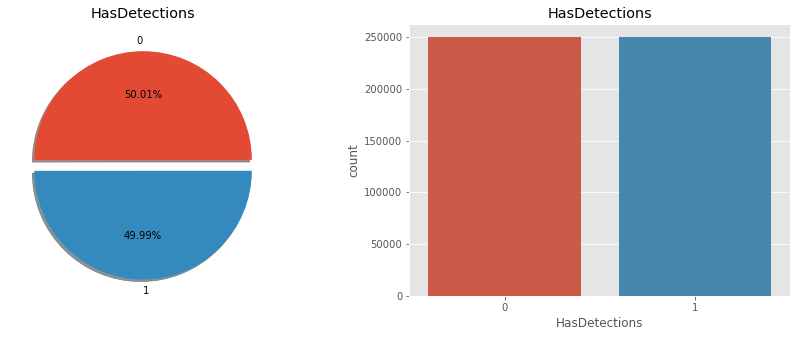

In [21]:
f,ax=plt.subplots(1,2,figsize=(15,5))
df['HasDetections'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.2f%%',ax=ax[0],shadow=True)
ax[0].set_title('HasDetections')
ax[0].set_ylabel('')
sns.countplot('HasDetections',data=df,ax=ax[1])
ax[1].set_title('HasDetections')
plt.show()

Podemos observar que tenemos un target totalmente balanceado. Con un total de 500 K registros, 49,99% de los cuales son positivos.

In [22]:
df['Target'] = (df['HasDetections'] == 1).astype(int)

### Identificación de outliers

A continuación vamos a realizar el análisis y detección de outliers para cada una de nuestras variables númericas.

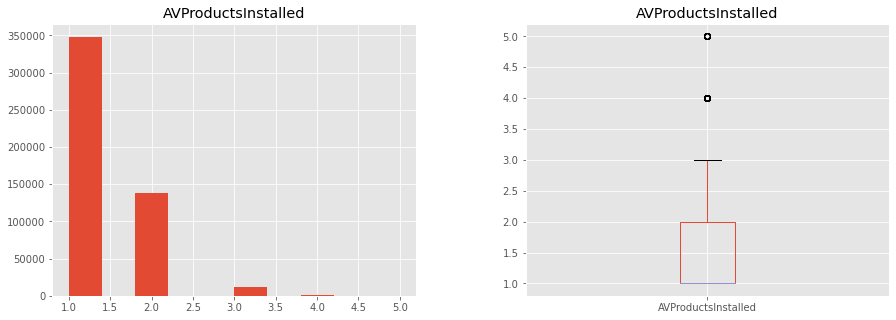

In [23]:
f,ax=plt.subplots(1,2,figsize=(15,5))
df.hist('AVProductsInstalled',ax=ax[0])
ax[0].set_title('AVProductsInstalled')
ax[0].set_ylabel('')
df.boxplot('AVProductsInstalled',ax=ax[1])
ax[1].set_title('AVProductsInstalled')
plt.show()

Este atributo tiene algunos outliers, eso es debido a que la mayoria de usuarios solo tienen 1 Antivirus instalado. Parece ser que hay muchos usuarios con 2 antivirus y algunos usuarios que tienen 3 o más instalados.

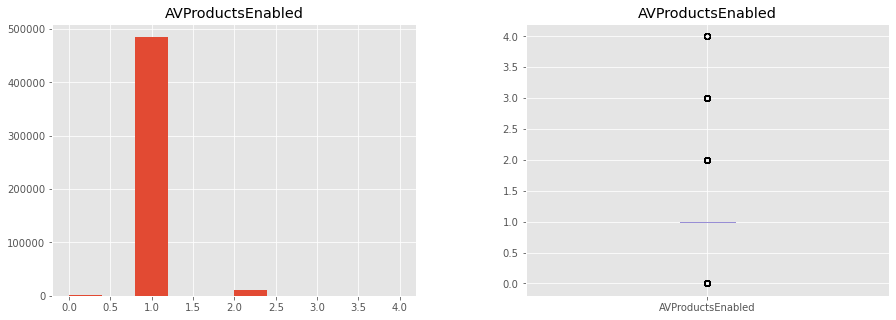

In [24]:
f,ax=plt.subplots(1,2,figsize=(15,5))
df.hist('AVProductsEnabled',ax=ax[0])
ax[0].set_title('AVProductsEnabled')
ax[0].set_ylabel('')
df.boxplot('AVProductsEnabled',ax=ax[1])
ax[1].set_title('AVProductsEnabled')
plt.show()

Este atributo yo lo entiendo como binario. Es decir, o tienes AV activado o no. Lo normal seria tener 0 o 1, pero al parecer hay registros con 2 y 3. Es como si algunos usuarios tuvieran más de un AV instalado.

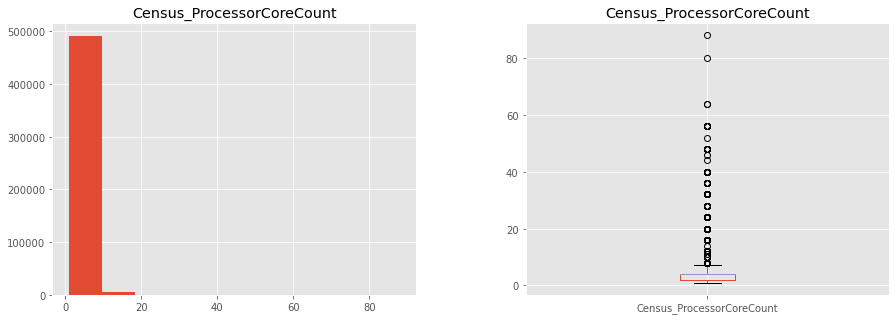

In [25]:
f,ax=plt.subplots(1,2,figsize=(15,5))
df.hist('Census_ProcessorCoreCount',ax=ax[0])
ax[0].set_title('Census_ProcessorCoreCount')
ax[0].set_ylabel('')
df.boxplot('Census_ProcessorCoreCount',ax=ax[1])
ax[1].set_title('Census_ProcessorCoreCount')
plt.show()

La cantidad de nucleos que tiene el processador también parece tener outliers. Esto es debido a que la mayoria de processadores tienen entre 2 y 6 nucleos.

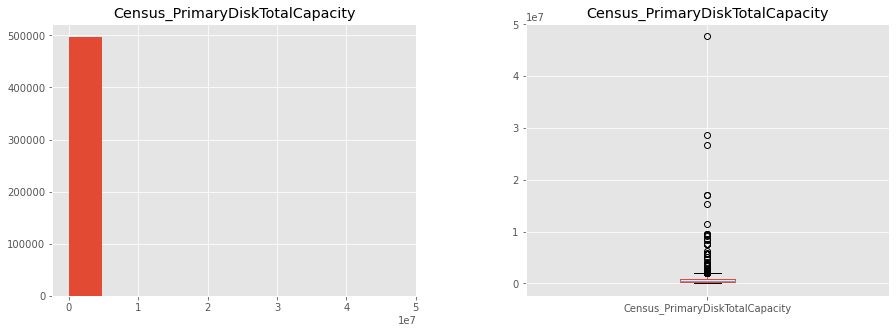

In [26]:
f,ax=plt.subplots(1,2,figsize=(15,5))
df.hist('Census_PrimaryDiskTotalCapacity',ax=ax[0])
ax[0].set_title('Census_PrimaryDiskTotalCapacity')
ax[0].set_ylabel('')
df.boxplot('Census_PrimaryDiskTotalCapacity',ax=ax[1])
ax[1].set_title('Census_PrimaryDiskTotalCapacity')
plt.show()

La capacidad total del disco duro, está medida en MB. La mayoria de dispositvos tienen un capacidad total de disco etre los 100GB y 500GB. Por eso todos aquellos superiores aparecen como outliers

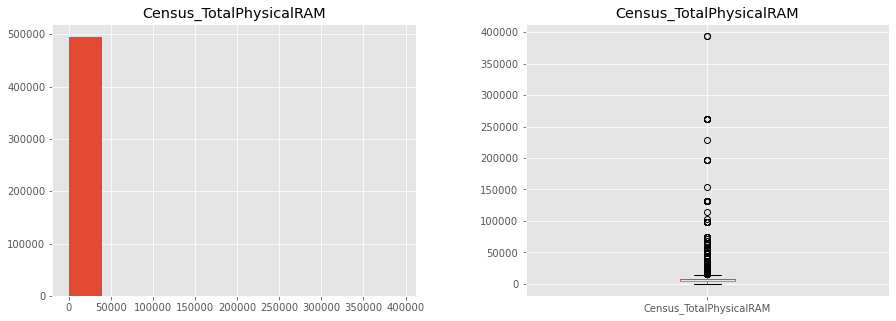

In [27]:
f,ax=plt.subplots(1,2,figsize=(15,5))
df.hist('Census_TotalPhysicalRAM',ax=ax[0])
ax[0].set_title('Census_TotalPhysicalRAM')
ax[0].set_ylabel('')
df.boxplot('Census_TotalPhysicalRAM',ax=ax[1])
ax[1].set_title('Census_TotalPhysicalRAM')
plt.show()

La capacidad de la RAM está medida en MB, por tiene valores tan elevados. Nos aparecen muchos outliers porque la mayoria de RAM estan entre los 2GB y los 8GB.

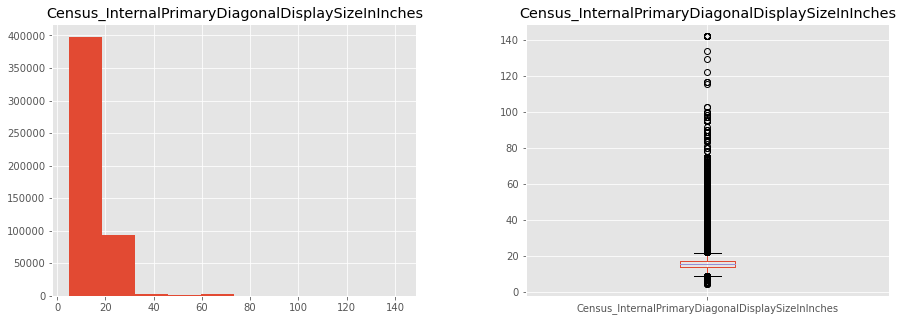

In [28]:
f,ax=plt.subplots(1,2,figsize=(15,5))
df.hist('Census_InternalPrimaryDiagonalDisplaySizeInInches',ax=ax[0])
ax[0].set_title('Census_InternalPrimaryDiagonalDisplaySizeInInches')
ax[0].set_ylabel('')
df.boxplot('Census_InternalPrimaryDiagonalDisplaySizeInInches',ax=ax[1])
ax[1].set_title('Census_InternalPrimaryDiagonalDisplaySizeInInches')
plt.show()

Este atributo se mide en pulgadas, como podemos ver existen muchos registros con una cantidad total de 900 pulgadas registradas. Este valor es extremadamente elevado y asumiremos que tiene que ser algún error. Posiblemente han introducido estos datos en cm y no en pulgadas. Por lo que convertiremos estos resultados de 900 cm a 354 pulgadas que es un valor más razonable.

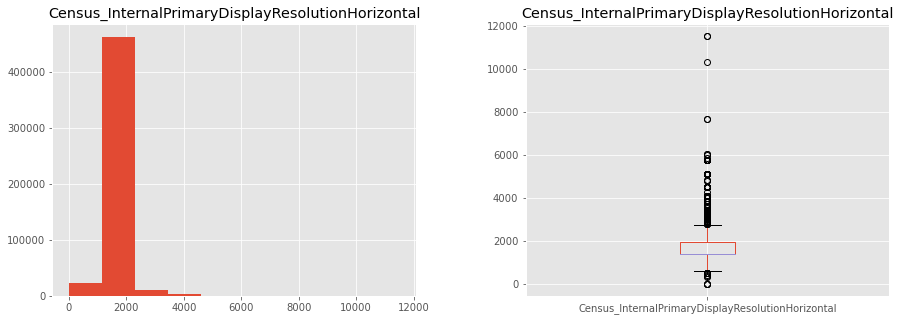

In [29]:
f,ax=plt.subplots(1,2,figsize=(15,5))
df.hist('Census_InternalPrimaryDisplayResolutionHorizontal',ax=ax[0])
ax[0].set_title('Census_InternalPrimaryDisplayResolutionHorizontal')
ax[0].set_ylabel('')
df.boxplot('Census_InternalPrimaryDisplayResolutionHorizontal',ax=ax[1])
ax[1].set_title('Census_InternalPrimaryDisplayResolutionHorizontal')
plt.show()

La mayoria de resultados estan entre los 500 y los 2500. Por eso los demás nos aparecen como outliers. 

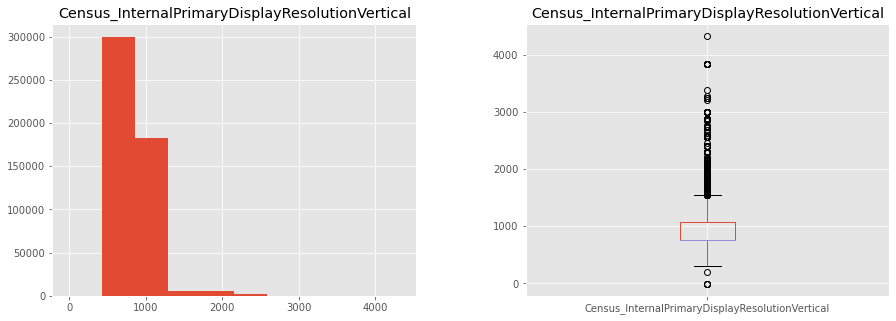

In [30]:
f,ax=plt.subplots(1,2,figsize=(15,5))
df.hist('Census_InternalPrimaryDisplayResolutionVertical',ax=ax[0])
ax[0].set_title('Census_InternalPrimaryDisplayResolutionVertical')
ax[0].set_ylabel('')
df.boxplot('Census_InternalPrimaryDisplayResolutionVertical',ax=ax[1])
ax[1].set_title('Census_InternalPrimaryDisplayResolutionVertical')
plt.show()

La mayoria de resultados estan entre los 500 y los 1500. Por eso los demás nos aparecen como outliers. 

### Correlación con el target

A continuación vamos a analizar la relación de cada una de nuestras variables con el target que queremos predecir. Para ver cuantas de ellas esperamos encontrar en nuestro modelo DT.

Tambiém aprobecharemos para ir transformando las variables según las vayamos analizando y relacionando con el target.

In [31]:
def set_others(df, column, num_values):
    top_categories = df[column].value_counts().head(num_values)
    top_categories_list = top_categories.index.to_list()
    top_categories_list.append('Others')
    return pd.Categorical(df[column], categories=top_categories_list).fillna('Others')

In [32]:
def plot_categories(df, column, target):
    plt.figure(figsize=(15,8))

    ax1 = plt.subplot(2,1,1)
    sns.countplot(
        df[column]
    )
    
    plt.xticks=([])
    
    ax2 = plt.subplot(2,1,2, sharex=ax1)
    sns.boxenplot(
        data = df[df[target] > 0], 
        x = column,
        y = target
    )

    plt.xticks(rotation=45)
    
    plt.show()

In [33]:
def explore_values(column_name, df, target):
    value_count = df[column_name].value_counts()
    percentages = df[column_name].value_counts(normalize=True)
    mean_values = df[df[target] > 0].pivot_table(index=column_name, values=target, aggfunc=[np.mean])

    results_df = pd.concat([value_count, percentages, mean_values], axis=1)
    results_df.columns = ['count', 'pct', 'mean_target']

    return results_df.sort_values(by='mean_target', ascending=False)

#### Product Name

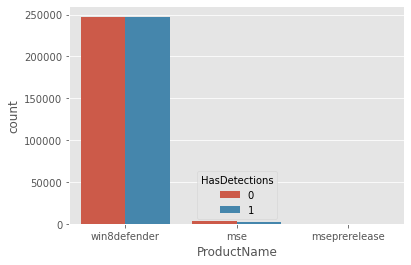

In [34]:
sns.countplot(data=df, x='ProductName', hue='HasDetections')

In [35]:
explore_values('ProductName', df, 'HasDetections')

,count,pct,mean_target
win8defender,494604,0.99,1.00
mse,5395,0.01,1.00
mseprerelease,1,0.00,nan


Esta variable no aporta información relevante ya que el 99% son del mismo tipo y solo tiene 50% de relación con el target.

#### EngineVersion

La versión de la máquina como se puede observar tiene 2 principales versiones que agrupan el 84% de los casos. Al ser un número ordinal, vamos a transformar su tipo a Integer.

In [36]:
df['EngineVersion'].value_counts(dropna=False, normalize=True).head(12)

1.1.15200.1   0.43
1.1.15100.1   0.41
1.1.15000.2   0.03
1.1.14901.4   0.02
1.1.14600.4   0.02
1.1.14800.3   0.02
1.1.15300.6   0.01
1.1.14104.0   0.01
1.1.15300.5   0.01
1.1.13504.0   0.01
1.1.14700.5   0.01
1.1.14500.5   0.01
Name: EngineVersion, dtype: float64

In [37]:
explore_values('EngineVersion', df, 'HasDetections')

,count,pct,mean_target
1.1.15200.1,216491,0.43,1.00
1.1.14500.2,19,0.00,1.00
1.1.13202.0,245,0.00,1.00
1.1.13103.0,235,0.00,1.00
1.1.13000.0,220,0.00,1.00
1.1.15000.1,138,0.00,1.00
1.1.12805.0,115,0.00,1.00
1.1.14901.3,71,0.00,1.00
1.1.14700.4,65,0.00,1.00
1.1.14700.3,61,0.00,1.00


In [38]:
df['EngineVersion'] = df['EngineVersion'].str.replace('.', '').astype(int)

In [39]:
df['EngineVersion'].value_counts(dropna=False, normalize=True)

11152001   0.43
11151001   0.41
11150002   0.03
11149014   0.02
11146004   0.02
11148003   0.02
11153006   0.01
11141040   0.01
11153005   0.01
11135040   0.01
11147005   0.01
11145005   0.01
11144052   0.00
11143060   0.00
11142020   0.00
11140030   0.00
11133030   0.00
11139030   0.00
11138040   0.00
11134070   0.00
11136010   0.00
11129020   0.00
11143050   0.00
11137040   0.00
11137010   0.00
11132020   0.00
11131030   0.00
11130000   0.00
11150001   0.00
11128050   0.00
11149013   0.00
11147004   0.00
11147003   0.00
11148001   0.00
11145002   0.00
11142010   0.00
11143030   0.00
11121010   0.00
11141030   0.00
11139020   0.00
11138020   0.00
11128040   0.00
11126030   0.00
11117010   0.00
11138030   0.00
11140020   0.00
11140010   0.00
11141020   0.00
11134060   0.00
11127060   0.00
11131020   0.00
11104010   0.00
11124000   0.00
Name: EngineVersion, dtype: float64

#### AppVersion

En la versión de la App, si nos fijamos con las primeras 10 versiones ya tenemos cubierto el 90% de los casos. Vamos a agrupar el resto creando un grupo llamado otros.

In [40]:
df['AppVersion'].describe()

count              500000
unique                 95
top       4.18.1807.18075
freq               288809
Name: AppVersion, dtype: object

In [41]:
df['AppVersion'].value_counts(dropna=False, normalize=True).head(10)

4.18.1807.18075    0.58
4.18.1806.18062    0.10
4.12.16299.15      0.04
4.10.209.0         0.03
4.13.17134.1       0.03
4.16.17656.18052   0.03
4.13.17134.228     0.03
4.9.10586.1106     0.02
4.8.10240.17443    0.02
4.14.17639.18041   0.02
Name: AppVersion, dtype: float64

In [42]:
df['AppVersion'] = set_others(df, 'AppVersion', 10)

In [43]:
df['AppVersion'].value_counts(dropna=False, normalize=True)

4.18.1807.18075    0.58
Others             0.11
4.18.1806.18062    0.10
4.12.16299.15      0.04
4.10.209.0         0.03
4.13.17134.1       0.03
4.16.17656.18052   0.03
4.13.17134.228     0.03
4.9.10586.1106     0.02
4.8.10240.17443    0.02
4.14.17639.18041   0.02
Name: AppVersion, dtype: float64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text major ticklabel objects>)

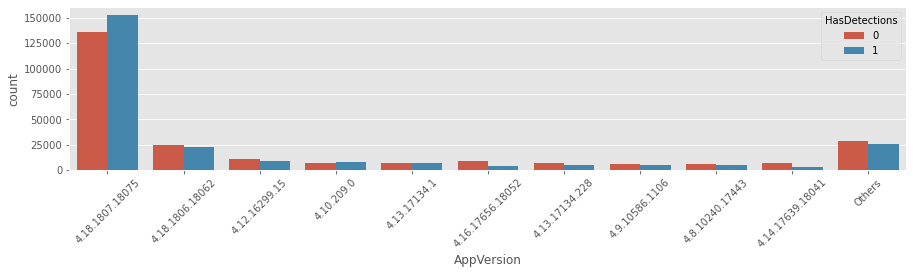

In [44]:
plt.figure(figsize=(15,3))
sns.countplot(data=df, x='AppVersion', hue='HasDetections')
plt.xticks(rotation=45)

#### AvSigVersion

In [45]:
df['AvSigVersion'].describe()

count           500000
unique            6455
top       1.273.1420.0
freq              5771
Name: AvSigVersion, dtype: object

In [46]:
df['AvSigVersion'].value_counts(dropna=False).head(50)

1.273.1420.0    5771
1.263.48.0      5537
1.275.1140.0    5317
1.275.727.0     5214
1.273.371.0     4799
1.273.1826.0    4744
1.275.1244.0    4487
1.251.42.0      4258
1.275.1209.0    3787
1.273.810.0     3708
1.237.0.0       3534
1.273.1749.0    3508
1.273.1379.0    2789
1.273.1005.0    2747
1.273.894.0     2540
1.273.781.0     2409
1.273.461.0     2332
1.273.337.0     2219
1.273.1527.0    2218
1.275.948.0     2170
1.275.1293.0    2086
1.273.1167.0    2081
1.273.717.0     2060
1.273.950.0     1979
1.275.1487.0    1923
1.275.1025.0    1916
1.273.1034.0    1872
1.275.511.0     1807
1.273.1112.0    1796
1.273.1311.0    1769
1.275.981.0     1738
1.275.1011.0    1732
1.273.1795.0    1730
1.275.1669.0    1708
1.275.974.0     1683
1.275.112.0     1670
1.273.1056.0    1654
1.275.263.0     1633
1.273.665.0     1628
1.275.1086.0    1615
1.273.1282.0    1605
1.273.1574.0    1551
1.273.1073.0    1523
1.273.1668.0    1497
1.273.933.0     1484
1.275.1458.0    1468
1.275.1349.0    1448
1.275.941.0  

In [47]:
explore_values('AvSigVersion', df, 'HasDetections')

,count,pct,mean_target
1.273.1420.0,5771,0.01,1.00
1.255.335.0,4,0.00,1.00
1.255.110.0,4,0.00,1.00
1.261.752.0,4,0.00,1.00
1.243.242.0,4,0.00,1.00
...,...,...,...
1.249.670.0,1,0.00,nan
1.227.2034.0,1,0.00,nan
1.239.1128.0,1,0.00,nan
1.227.1364.0,1,0.00,nan


In [48]:
df['AvSigVersion'] = df['AvSigVersion'].str.slice(stop=5)

In [49]:
df['AvSigVersion'].value_counts(dropna=False, normalize=True).head(11)

1.275   0.44
1.273   0.42
1.271   0.03
1.269   0.02
1.263   0.02
1.267   0.02
1.251   0.01
1.277   0.01
1.237   0.01
1.261   0.01
1.265   0.01
Name: AvSigVersion, dtype: float64

In [50]:
df['AvSigVersion'] = set_others(df, 'AvSigVersion', 11)

In [51]:
df['AvSigVersion'].value_counts(dropna=False, normalize=True)

1.275    0.44
1.273    0.42
1.271    0.03
1.269    0.02
Others   0.02
1.263    0.02
1.267    0.02
1.251    0.01
1.277    0.01
1.237    0.01
1.261    0.01
1.265    0.01
Name: AvSigVersion, dtype: float64

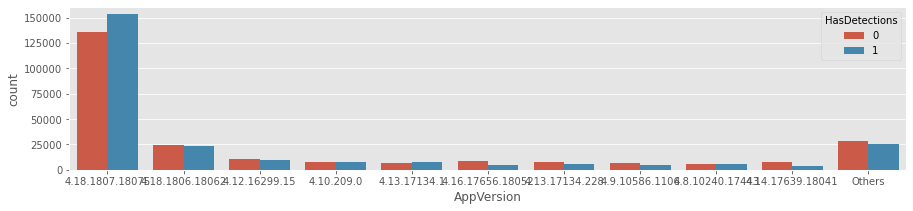

In [52]:
plt.figure(figsize=(15,3))
sns.countplot(data=df, x='AppVersion', hue='HasDetections')

Se puede ver como en el primer caso, si que tiene una clara relación con el target.

#### IsBeta

In [53]:
df.pivot_table(index='IsBeta', values='HasDetections', aggfunc=[len, np.sum, np.mean])

,len,sum,mean
,HasDetections,HasDetections,HasDetections
IsBeta,,,
0,499999,249953,0.50
1,1,0,0.00


Este atributo no nos aporta valor, todos sus valores menos uno son 0. Y los demás estan al 50% de relación con el target.

#### RtpStateBitfield

El 90% de los registros lo conforman los grupos 7 y 0. Vamos a agrupar los demás resultados en la categoria Others.

In [54]:
df['RtpStateBitfield'].value_counts(dropna=False)

7.00     484841
0.00      10610
nan        1832
8.00       1277
5.00       1158
3.00        176
1.00        105
35.00         1
Name: RtpStateBitfield, dtype: int64

In [55]:
df.pivot_table(index='RtpStateBitfield', values='HasDetections', aggfunc=[len, np.sum, np.mean])

,len,sum,mean
,HasDetections,HasDetections,HasDetections
RtpStateBitfield,,,
0.00,10610,4043,0.38
1.00,105,34,0.32
3.00,176,49,0.28
5.00,1158,175,0.15
7.00,484841,243855,0.50
8.00,1277,978,0.77
35.00,1,1,1.00


In [56]:
df['RtpStateBitfield'].fillna(value=-999, inplace=True)

In [57]:
df['RtpStateBitfield'].value_counts(dropna=False)

7.00       484841
0.00        10610
-999.00      1832
8.00         1277
5.00         1158
3.00          176
1.00          105
35.00           1
Name: RtpStateBitfield, dtype: int64

In [58]:
df['RtpStateBitfield'] = set_others(df, 'RtpStateBitfield', 2)

In [59]:
df['RtpStateBitfield'].value_counts(dropna=False)

7.0       484841
0.0        10610
Others      4549
Name: RtpStateBitfield, dtype: int64

#### IsSxsPassiveMode

In [60]:
df.pivot_table(index='IsSxsPassiveMode', values='HasDetections', aggfunc=[len, np.sum, np.mean])

,len,sum,mean
,HasDetections,HasDetections,HasDetections
IsSxsPassiveMode,,,
0,491379,246751,0.50
1,8621,3202,0.37


Como se puede observar, este atributo no parece aportar mucha información

#### DefaultBrowsersIdentifier

Este atributo tiene más de un 95% de valores nulos. Además si nos fijamos el peso esta concentrado en los primeros 6 registros.

In [61]:
df['DefaultBrowsersIdentifier'].value_counts(dropna=False).head(20)

nan         475939
239.00        2589
3,195.00      2423
1,632.00      1601
3,176.00      1313
146.00        1231
1,910.00      1067
1,727.00       968
2,064.00       760
2,725.00       724
1,160.00       690
788.00         626
1,536.00       623
1,078.00       601
1,623.00       549
2,273.00       392
1,823.00       382
2,388.00       374
2,290.00       372
614.00         366
Name: DefaultBrowsersIdentifier, dtype: int64

In [62]:
explore_values('DefaultBrowsersIdentifier', df, 'HasDetections')

,count,pct,mean_target
1.00,2,0.00,1.00
"2,179.00",6,0.00,1.00
"2,247.00",6,0.00,1.00
"2,226.00",1,0.00,1.00
"2,221.00",1,0.00,1.00
...,...,...,...
"3,083.00",1,0.00,nan
"3,094.00",1,0.00,nan
"3,101.00",1,0.00,nan
"3,116.00",1,0.00,nan


In [63]:
df['DefaultBrowsersIdentifier'].fillna(value=-999, inplace=True)

In [64]:
df['DefaultBrowsersIdentifier'] = set_others(df, 'DefaultBrowsersIdentifier', 6)

In [65]:
df['DefaultBrowsersIdentifier'].value_counts(dropna=False)

-999.0    475939
Others     14904
239.0       2589
3195.0      2423
1632.0      1601
3176.0      1313
146.0       1231
Name: DefaultBrowsersIdentifier, dtype: int64

In [66]:
df.pivot_table(index='DefaultBrowsersIdentifier', values='HasDetections', aggfunc=[len, np.sum, np.mean])

,len,sum,mean
,HasDetections,HasDetections,HasDetections
DefaultBrowsersIdentifier,,,
-999.0,475939,238846,0.50
239.0,2589,1481,0.57
3195.0,2423,1358,0.56
1632.0,1601,688,0.43
3176.0,1313,503,0.38
146.0,1231,445,0.36
Others,14904,6632,0.44


Se puede ver como para los navegadores **239** y **3195** si parecen tener algo relación con la detección de malware

#### AVProductStatesIdentifier

Podemos ver como con los primeros 13 AVProducts ya tenemos el 90% de los registros.

In [67]:
df['AVProductStatesIdentifier'].value_counts(dropna=False, normalize=True).head(20)

53,447.00   0.65
7,945.00    0.05
47,238.00   0.04
62,773.00   0.03
46,413.00   0.01
23,657.00   0.01
49,480.00   0.01
41,571.00   0.01
29,199.00   0.01
51,954.00   0.01
22,728.00   0.01
46,669.00   0.01
43,856.00   0.01
43,927.00   0.00
3,371.00    0.00
6,630.00    0.00
nan         0.00
68,585.00   0.00
40,431.00   0.00
61,343.00   0.00
Name: AVProductStatesIdentifier, dtype: float64

In [68]:
df['AVProductStatesIdentifier'] = set_others(df, 'AVProductStatesIdentifier', 13)

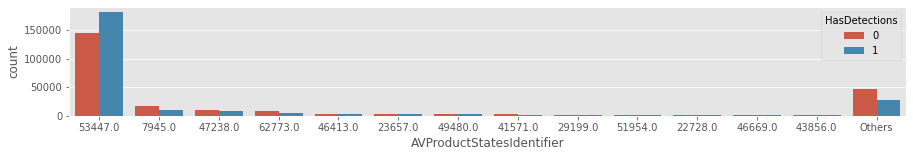

In [69]:
plt.figure(figsize=(15,2))
sns.countplot(data=df, x='AVProductStatesIdentifier', hue='HasDetections')

Se puede ver claramente como para el AVProduct **53447** hay una clara relación con la detección de malware

#### AVProductsInstalled

Con los 3 primeros valores ya se obtien el 90% de los casos. Al ser una variable numérica, simplemente trataremos los valores nulos.

In [70]:
df['AVProductsInstalled'].value_counts(dropna=False, normalize=True)

1.00   0.70
2.00   0.28
3.00   0.02
nan    0.00
4.00   0.00
5.00   0.00
Name: AVProductsInstalled, dtype: float64

In [71]:
df['AVProductsInstalled'].fillna(value=-999, inplace=True)

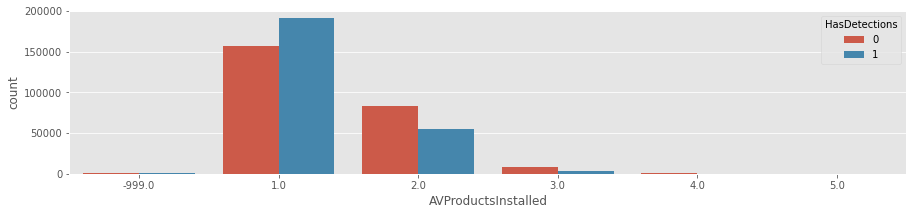

In [72]:
plt.figure(figsize=(15,3))
sns.countplot(data=df, x='AVProductsInstalled', hue='HasDetections')

Al parecer los equipos que tienen instalado 1 solo antivirus son los que tienen mayor relación con el target

#### AVProductsEnabled

Con los 2 primeros valores ya se obtien el 99% de los casos. Es curioso ver que hay equipos con más de 1 antivirus instalado. Al ser una variable numérica, simplemente trataremos los valores nulos.

In [73]:
df['AVProductsEnabled'].value_counts(dropna=False, normalize=True)

1.00   0.97
2.00   0.02
nan    0.00
0.00   0.00
3.00   0.00
4.00   0.00
Name: AVProductsEnabled, dtype: float64

In [74]:
df['AVProductsEnabled'].fillna(value=-999, inplace=True)

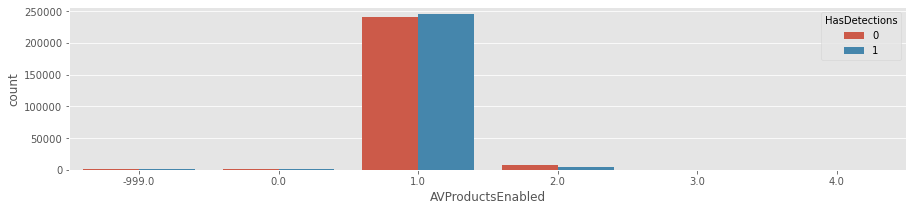

In [75]:
plt.figure(figsize=(15,3))
sns.countplot(data=df, x='AVProductsEnabled', hue='HasDetections')

Parece tener alguna ligera relación para los casos que solo tienen un antivirus activado. Como es lógico tiene mucha relación con el anterior atributo

#### HasTpm

In [76]:
df['HasTpm'].value_counts(dropna=False, normalize=True)

1   0.99
0   0.01
Name: HasTpm, dtype: float64

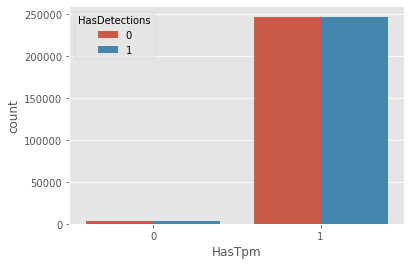

In [77]:
sns.countplot(data=df, x='HasTpm', hue='HasDetections')

No aporta mucho, el 99% de sus valores es 1. Además cuando esta activado Tpm la relación con el target es 50%.

#### CountryIdentifier

Podemos ver que hay unos 10 paises en los cuales si parece haber una relación positiva con el target.

In [78]:
df['CountryIdentifier'].value_counts(dropna=False, normalize=True).head(50)

43    0.04
29    0.04
141   0.04
93    0.03
171   0.03
60    0.03
201   0.02
207   0.02
66    0.02
89    0.02
97    0.02
214   0.02
158   0.02
44    0.02
9     0.02
107   0.02
68    0.02
41    0.02
51    0.02
203   0.02
35    0.02
149   0.01
160   0.01
195   0.01
142   0.01
205   0.01
155   0.01
164   0.01
173   0.01
88    0.01
159   0.01
59    0.01
101   0.01
12    0.01
220   0.01
91    0.01
169   0.01
50    0.01
80    0.01
2     0.01
19    0.01
57    0.01
84    0.01
177   0.01
11    0.01
18    0.01
95    0.01
21    0.01
110   0.01
178   0.01
Name: CountryIdentifier, dtype: float64

In [79]:
df['CountryIdentifier'] = set_others(df, 'CountryIdentifier', 50)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
 <a list of 51 Text major ticklabel objects>)

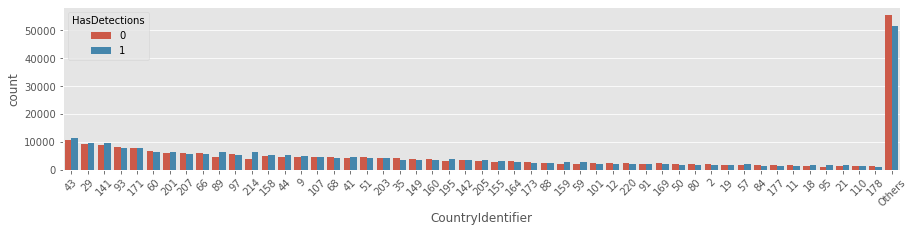

In [80]:
plt.figure(figsize=(15,3))
sns.countplot(data=df, x='CountryIdentifier', hue='HasDetections')
plt.xticks(rotation=45)

#### CityIdentifier

Vemos que no todas las ciudades estan informadas, de ser así no podriamos quedar con esta información y eliminar la columna país.

In [81]:
df['CityIdentifier'].value_counts(dropna=False, normalize=True).head(20)

nan          0.04
130,775.00   0.01
16,668.00    0.01
82,373.00    0.01
10,222.00    0.01
61,668.00    0.01
143,782.00   0.01
66,202.00    0.01
58,607.00    0.01
92,213.00    0.01
66,953.00    0.01
22,656.00    0.01
96,401.00    0.01
136,271.00   0.01
74,924.00    0.00
39,800.00    0.00
143,155.00   0.00
37,376.00    0.00
20,805.00    0.00
67,513.00    0.00
Name: CityIdentifier, dtype: float64

Vamos a tratar los nulos

In [82]:
df['CityIdentifier'].fillna(value=-999, inplace=True)

In [83]:
df['CityIdentifier'].value_counts(dropna=False, normalize=True).head(20)

-999.00      0.04
130,775.00   0.01
16,668.00    0.01
82,373.00    0.01
10,222.00    0.01
61,668.00    0.01
143,782.00   0.01
66,202.00    0.01
58,607.00    0.01
92,213.00    0.01
66,953.00    0.01
22,656.00    0.01
96,401.00    0.01
136,271.00   0.01
74,924.00    0.00
39,800.00    0.00
143,155.00   0.00
37,376.00    0.00
20,805.00    0.00
67,513.00    0.00
Name: CityIdentifier, dtype: float64

In [84]:
df['CityIdentifier'] = set_others(df, 'CityIdentifier', 20)

#### OrganizationIdentifier

Para la organización si nos fijamos solo hay un valor que sea realmente relevante, la organización número 27. Los demás son prácticamente testimoniales. Además hay una gran cantidad de nulos.

In [85]:
explore_values('OrganizationIdentifier',df,'HasDetections')

,count,pct,mean_target
1.00,39,0.00,1.00
42.00,8,0.00,1.00
32.00,230,0.00,1.00
33.00,171,0.00,1.00
35.00,2,0.00,1.00
36.00,207,0.00,1.00
37.00,1048,0.00,1.00
39.00,21,0.00,1.00
40.00,100,0.00,1.00
41.00,2,0.00,1.00


In [86]:
df['OrganizationIdentifier'] = set_others(df, 'OrganizationIdentifier', 2)

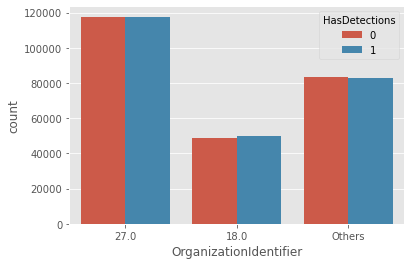

In [87]:
sns.countplot(data=df, x='OrganizationIdentifier', hue='HasDetections')

#### GeoNameIdentifier 

Este atributo puede parece redundante debido a que nos muestra la region donde esta localizado el dispositivo. Ahora bien esto puede tener sentido, ya que un virus puede circular por alguna region en concreto mientras. Al viajar la gente es posible que se le infecte el dispotivo.

In [88]:
explore_values('GeoNameIdentifier', df, 'HasDetections').head(100)

,count,pct,mean_target
1.00,54,0.00,1.00
153.00,14,0.00,1.00
189.00,1,0.00,1.00
190.00,3,0.00,1.00
191.00,12,0.00,1.00
192.00,2010,0.00,1.00
193.00,615,0.00,1.00
194.00,1272,0.00,1.00
195.00,8,0.00,1.00
196.00,110,0.00,1.00


In [89]:
df['GeoNameIdentifier'].value_counts(dropna=False, normalize=True).head(30)

277.00   0.17
211.00   0.05
53.00    0.05
89.00    0.04
240.00   0.04
35.00    0.04
167.00   0.04
276.00   0.03
267.00   0.02
126.00   0.02
119.00   0.02
98.00    0.02
138.00   0.02
255.00   0.02
57.00    0.02
10.00    0.02
204.00   0.02
52.00    0.02
181.00   0.01
120.00   0.01
45.00    0.01
205.00   0.01
202.00   0.01
224.00   0.01
157.00   0.01
201.00   0.01
117.00   0.01
258.00   0.01
129.00   0.01
15.00    0.01
Name: GeoNameIdentifier, dtype: float64

In [90]:
df['GeoNameIdentifier'] = set_others(df, 'GeoNameIdentifier', 30)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 <a list of 31 Text major ticklabel objects>)

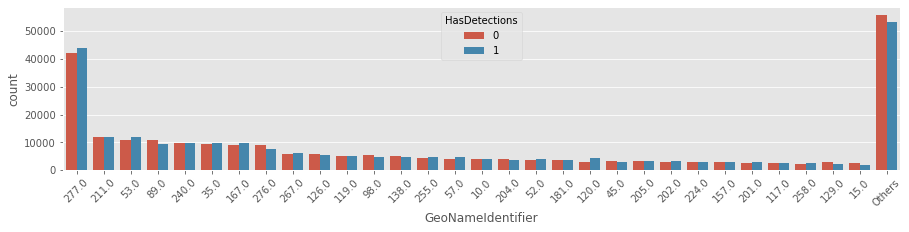

In [91]:
plt.figure(figsize=(15,3))
sns.countplot(data=df, x='GeoNameIdentifier', hue='HasDetections')
plt.xticks(rotation=45)

Solo parece tener alguna ligera relación para la region 277

#### LocaleEnglishNameIdentifier

Este atributo nos aportaria mucha información de tener el nombre en ingles del identificador. 

In [92]:
df['LocaleEnglishNameIdentifier'].value_counts(dropna=False, normalize=True).head(30)

75    0.24
182   0.05
42    0.05
74    0.05
88    0.04
233   0.04
171   0.04
227   0.04
251   0.02
124   0.02
103   0.02
134   0.02
64    0.02
46    0.02
218   0.02
214   0.02
217   0.02
170   0.02
56    0.01
172   0.01
70    0.01
68    0.01
231   0.01
60    0.01
115   0.01
126   0.01
58    0.01
16    0.01
51    0.01
72    0.01
Name: LocaleEnglishNameIdentifier, dtype: float64

In [93]:
df['LocaleEnglishNameIdentifier'] = set_others(df, 'LocaleEnglishNameIdentifier', 30)

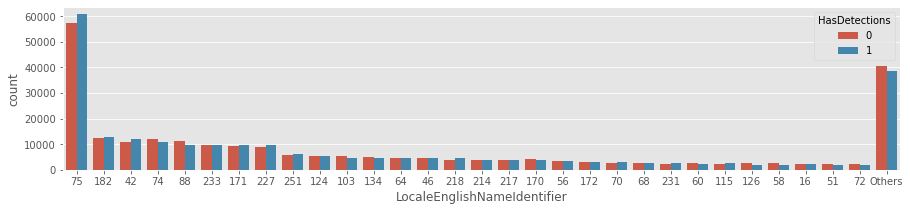

In [94]:
plt.figure(figsize=(15,3))
sns.countplot(data=df, x='LocaleEnglishNameIdentifier', hue='HasDetections')

Como se puede ver solo tiene una clare relación con la detección de malware para la region 75.

#### Platform

In [95]:
df['Platform'].value_counts(dropna=False, normalize=True)

windows10     0.97
windows8      0.02
windows7      0.01
windows2016   0.00
Name: Platform, dtype: float64

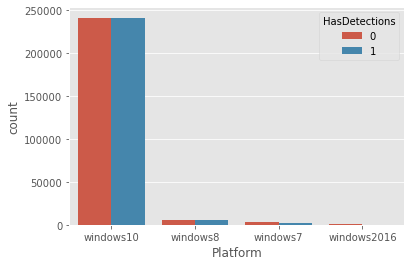

In [96]:
sns.countplot(data=df, x='Platform', hue='HasDetections')

Este atributo parece aportar poco, ya que el 97% de sus registros son para windows10. Además estám practicamente al 50%

#### Processor

In [97]:
explore_values('Processor', df, 'HasDetections')

,count,pct,mean_target
x64,454423,0.91,1.00
x86,45563,0.09,1.00
arm64,14,0.00,nan


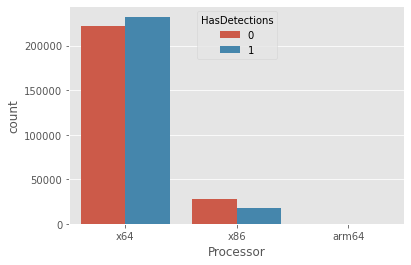

In [98]:
sns.countplot(data=df, x='Processor', hue='HasDetections')

Como se puede observar el 91% de los casos corresponden con un processador x64, y prácticamente esta al 50%.

#### OsVer

Para la version del Sistema Operativo, el 97% son **10.0.0.0** y con solo 3 valores abarcamos el 99% de los registros.

In [99]:
explore_values('OsVer', df, 'HasDetections')

,count,pct,mean_target
10.0.0.0,483830,0.97,1.00
6.3.0.0,10818,0.02,1.00
6.1.1.0,5281,0.01,1.00
6.1.0.0,33,0.00,1.00
10.0.3.0,12,0.00,1.00
10.0.1.0,7,0.00,1.00
6.3.1.0,2,0.00,1.00
10.0.0.1,2,0.00,1.00
10.0.2.0,1,0.00,1.00
10.0.0.112,1,0.00,1.00


In [100]:
df['OsVer'] = set_others(df, 'OsVer', 3)

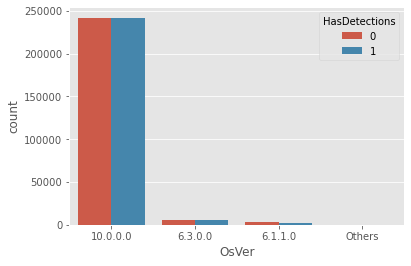

In [101]:
sns.countplot(data=df, x='OsVer', hue='HasDetections')

No parece que aporte mucha información con respecto al target.

#### OsBuild 

La construcción del sistema operativo actual, nos muestra como básicamente hay 3 construcciones claves la **17134**, **16299**, **15063**. Con ellas tres ya tenemos el 80% de los registros.

In [102]:
explore_values('OsBuild', df, 'HasDetections')

,count,pct,mean_target
7600,33,0.00,1.00
17747,3,0.00,1.00
17723,4,0.00,1.00
17730,3,0.00,1.00
17733,34,0.00,1.00
17735,37,0.00,1.00
17738,134,0.00,1.00
17741,51,0.00,1.00
17744,129,0.00,1.00
17746,62,0.00,1.00


In [103]:
df['OsBuild'].value_counts(dropna=False, normalize=True)

17134   0.44
16299   0.28
15063   0.09
14393   0.08
10586   0.05
10240   0.03
9600    0.02
7601    0.01
17692   0.00
17738   0.00
17744   0.00
17758   0.00
17746   0.00
17713   0.00
17754   0.00
17751   0.00
17741   0.00
17755   0.00
17735   0.00
17686   0.00
17733   0.00
17763   0.00
7600    0.00
17760   0.00
17682   0.00
17677   0.00
18234   0.00
17672   0.00
18242   0.00
18237   0.00
17661   0.00
17666   0.00
17723   0.00
17634   0.00
17730   0.00
17639   0.00
17747   0.00
17618   0.00
17655   0.00
17650   0.00
18219   0.00
17704   0.00
18214   0.00
17623   0.00
17604   0.00
17749   0.00
17753   0.00
17711   0.00
Name: OsBuild, dtype: float64

In [104]:
df['OsBuild'] = set_others(df, 'OsBuild', 8)

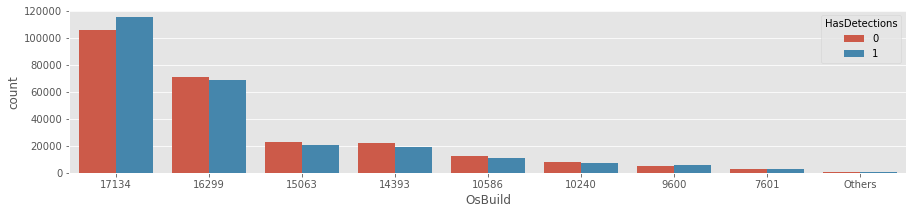

In [105]:
plt.figure(figsize=(15,3))
sns.countplot(data=df, x='OsBuild', hue='HasDetections')

#### OsSuite

In [106]:
explore_values('OsSuite', df, 'HasDetections')

,count,pct,mean_target
16,53,0.00,1
18,1,0.00,1
256,187951,0.38,1
272,677,0.00,1
274,2,0.00,1
305,33,0.00,1
400,47,0.00,1
768,311226,0.62,1
784,10,0.00,1


In [107]:
df['OsSuite'] = set_others(df, 'OsSuite', 2)

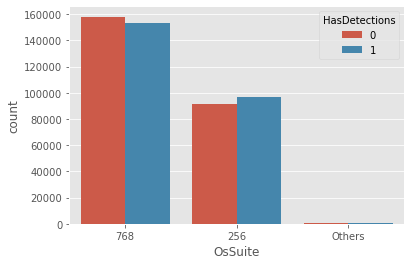

In [108]:
sns.countplot(data=df, x='OsSuite', hue='HasDetections')

#### OsPlatformSubRelease

In [109]:
explore_values('OsPlatformSubRelease', df, 'HasDetections')

,count,pct,mean_target
rs4,220779,0.44,1
rs3,139901,0.28,1
rs2,43352,0.09,1
rs1,40717,0.08,1
th2,22955,0.05,1
th1,15014,0.03,1
windows8.1,10825,0.02,1
windows7,5314,0.01,1
prers5,1143,0.00,1


In [110]:
df['OsPlatformSubRelease'] = set_others(df, 'OsPlatformSubRelease', 5)

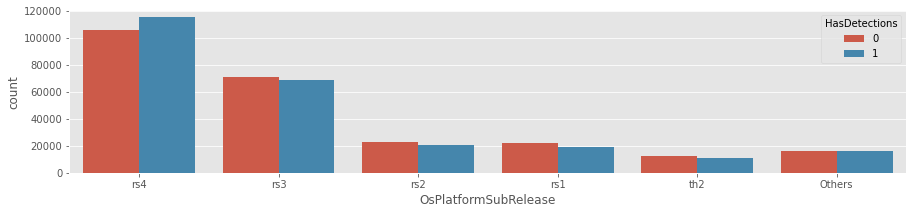

In [111]:
plt.figure(figsize=(15,3))
sns.countplot(data=df, x='OsPlatformSubRelease', hue='HasDetections')

Podemos ver que este atributo solo parece tener explicación con la detección de malware en el caso del **rs4**.

#### SkuEdition

Para este atributo, vemos como con solo dos variables abarcamos el 98% de los registros. Al solo tener 8 categorias para esta variable, no vamos agruparlas

In [112]:
explore_values('SkuEdition', df, 'HasDetections')

,count,pct,mean_target
Home,308567,0.62,1
Pro,181042,0.36,1
Invalid,4423,0.01,1
Education,2321,0.00,1
Enterprise,1999,0.00,1
Enterprise LTSB,1141,0.00,1
Cloud,309,0.00,1
Server,198,0.00,1


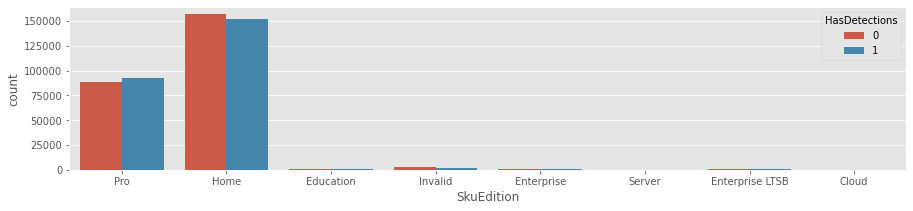

In [113]:
plt.figure(figsize=(15,3))
sns.countplot(data=df, x='SkuEdition', hue='HasDetections')

#### IsProtected

El 95% de las máquimas está protegida

In [114]:
explore_values('IsProtected', df, 'HasDetections')

,count,pct,mean_target
0.00,27001,0.05,1
1.00,471073,0.95,1


Al parecer tenemos algunos nulos por imputar. Viendo como se distribuyen los datos, vamos a darles el valor más probable que será 1.

In [115]:
df['IsProtected'].isnull().sum()

1926

In [116]:
df['IsProtected'].fillna(value=1, inplace=True)

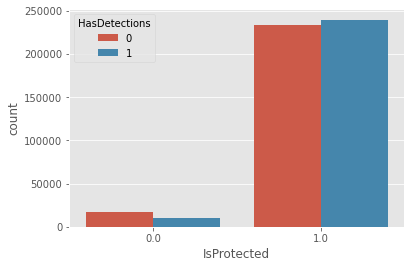

In [117]:
sns.countplot(data=df, x='IsProtected', hue='HasDetections')

Según podemos ver en el gráfico, hay una ligera relación positiva con el target, en el caso de estar protegido el equipo.

#### AutoSampleOptIn

Como podemos ver en los resultados del cuadro para esta variable, el 99% de los valores es identico. Con lo cual no aporta valor. Además dichos datos tienen un 50% de relación con el target. Por lo cual eliminaremos este atributo.

In [118]:
explore_values('AutoSampleOptIn', df, 'HasDetections')

,count,pct,mean_target
0,499986,1.00,1
1,14,0.00,1


In [119]:
df.drop('AutoSampleOptIn', axis=1, inplace=True)

#### SMode

Como podemos ver en los resultados del cuadro para esta variable, el 99% de los valores es identico. Con lo cual no aporta valor. Además dichos datos tienen un 50% de relación con el target. Por lo cual eliminaremos este atributo.

In [120]:
explore_values('SMode', df, 'HasDetections')

,count,pct,mean_target
0.00,469946,1.00,1
1.00,206,0.00,1


In [121]:
df.pivot_table(index='SMode', values='HasDetections', aggfunc=[len, np.sum, np.mean])

,len,sum,mean
,HasDetections,HasDetections,HasDetections
SMode,,,
0.00,469946,237451,0.51
1.00,206,37,0.18


In [122]:
df.drop('SMode', axis=1, inplace=True)

#### IeVerIdentifier

In [123]:
explore_values('IeVerIdentifier', df, 'HasDetections')

,count,pct,mean_target
8.00,1,0.00,1.00
295.00,128,0.00,1.00
284.00,14,0.00,1.00
285.00,3,0.00,1.00
287.00,7,0.00,1.00
...,...,...,...
390.00,1,0.00,nan
391.00,1,0.00,nan
395.00,1,0.00,nan
408.00,2,0.00,nan


In [124]:
df.pivot_table(index='IeVerIdentifier', values='HasDetections', aggfunc=[len, np.sum, np.mean])

,len,sum,mean
,HasDetections,HasDetections,HasDetections
IeVerIdentifier,,,
8.00,1,1,1.00
15.00,1,0,0.00
17.00,1,0,0.00
39.00,25,12,0.48
41.00,1918,926,0.48
...,...,...,...
407.00,1,1,1.00
408.00,2,0,0.00


In [125]:
df['IeVerIdentifier'].value_counts(dropna=False, normalize=True).head(20)

137.00   0.44
117.00   0.20
108.00   0.05
111.00   0.05
98.00    0.04
135.00   0.02
74.00    0.02
53.00    0.02
94.00    0.02
105.00   0.02
333.00   0.02
107.00   0.01
103.00   0.01
96.00    0.01
76.00    0.01
nan      0.01
71.00    0.00
41.00    0.00
114.00   0.00
323.00   0.00
Name: IeVerIdentifier, dtype: float64

In [126]:
df['IeVerIdentifier'].fillna(value=-999, inplace=True)

In [127]:
df['IeVerIdentifier'] = set_others(df, 'IeVerIdentifier', 11)

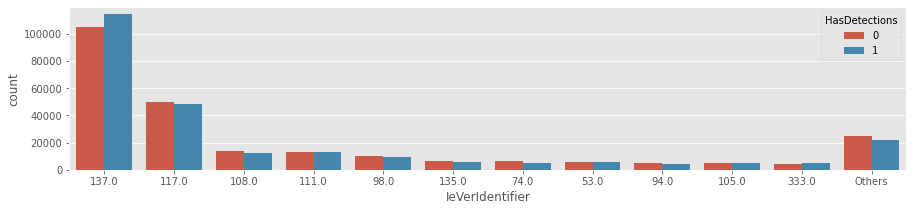

In [128]:
plt.figure(figsize=(15,3))
sns.countplot(data=df, x='IeVerIdentifier', hue='HasDetections')

En el gráfico anterior podemos ver como para la variable 137, hay una clara relación con el target.

#### SmartScreen

In [129]:
explore_values('SmartScreen', df, 'HasDetections')

,count,pct,mean_target
RequireAdmin,241594,0.75,1.00
ExistsNotSet,58497,0.18,1.00
Off,10388,0.03,1.00
Warn,7530,0.02,1.00
Prompt,1950,0.01,1.00
Block,1274,0.00,1.00
off,75,0.00,1.00
On,53,0.00,1.00
&#x02;,20,0.00,1.00
&#x01;,14,0.00,1.00


In [130]:
df[df['SmartScreen'] == 'off'] = df[df['SmartScreen'] == 'off'].replace('off','Off')

In [131]:
df[df['SmartScreen'] == 'on'] = df[df['SmartScreen'] == 'on'].replace('on','On')

In [132]:
df[df['SmartScreen'] == 'requireadmin'] = df[df['SmartScreen'] == 'requireadmin'].replace('requireadmin','RequireAdmin')

In [133]:
df['SmartScreen'].isnull().sum()

178596

In [134]:
df['SmartScreen'].fillna(value=-999, inplace=True)

In [135]:
explore_values('SmartScreen', df, 'HasDetections')

,count,pct,mean_target
RequireAdmin,241595,0.48,1
-999,178596,0.36,1
ExistsNotSet,58497,0.12,1
Off,10463,0.02,1
Warn,7530,0.02,1
Prompt,1950,0.00,1
Block,1274,0.00,1
On,61,0.00,1
&#x02;,20,0.00,1
&#x01;,14,0.00,1


In [136]:
df['SmartScreen'] = set_others(df, 'SmartScreen', 5)

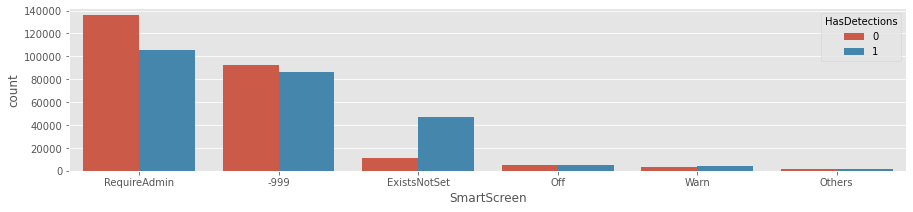

In [137]:
plt.figure(figsize=(15,3))
sns.countplot(data=df, x='SmartScreen', hue='HasDetections')

Solo parece tener relación en los casos categorizados como **ExistsNotSet** que son los casos en los que el valor existe pero está en blanco o no informado. Se podría considerar como un nulo.

#### Firewall

En el casos del cortafuegos, vemos como el 98% de sus atributos corresponden al mismo valor 1. Indicando que el cortafuegos está activado. Además cuando está activado solo muestra un 50% de relación con el target.

In [138]:
explore_values('Firewall', df, 'HasDetections')

,count,pct,mean_target
0.00,10767,0.02,1
1.00,484071,0.98,1


In [139]:
df.pivot_table(index='Firewall', values='HasDetections', aggfunc=[len, np.sum, np.mean])

,len,sum,mean
,HasDetections,HasDetections,HasDetections
Firewall,,,
0.00,10767,5308,0.49
1.00,484071,242106,0.50


En este caos, los valores nulos los vamos a imputar a la categoria más probable que será 1.

In [140]:
df['Firewall'].isnull().sum()

5162

In [141]:
df['Firewall'].fillna(value=1, inplace=True)

No vamos a proceder a eliminar este atributo, ya que como vamos a realizar un DT quizás en combinación con otras puede darnos información valiosa.

#### UacLuaenable

Para este atributo y segun su descripción, se esperaria encontrar resultados 1 o 0. Al parecer hay algunos errores de imputación que debemos corregir.

In [142]:
explore_values('UacLuaenable', df, 'HasDetections')

,count,pct,mean_target
0.00,3086,0.01,1
1.00,496276,0.99,1
2.00,1,0.00,1
48.00,13,0.00,1
"6,357,062.00",1,0.00,1


In [143]:
df[df['UacLuaenable'] > 1] = df[df['UacLuaenable'] > 1].replace(48.00,1.00)

In [144]:
df[df['UacLuaenable'] > 1] = df[df['UacLuaenable'] > 1].replace(6357062.00,1.00)

In [145]:
df['UacLuaenable'].isnull().sum()

623

In [146]:
df['UacLuaenable'].fillna(value=1, inplace=True)

#### Census_MDC2FormFactor

Para este atributo, si nos fijamos bien, con los primeros dos categorias ya abarcamos el 86% de los registros.

In [147]:
explore_values('Census_MDC2FormFactor', df, 'HasDetections')

,count,pct,mean_target
Notebook,320948,0.64,1.00
Desktop,109527,0.22,1.00
Convertible,22369,0.04,1.00
Detachable,16802,0.03,1.00
AllInOne,16372,0.03,1.00
PCOther,7800,0.02,1.00
LargeTablet,3645,0.01,1.00
SmallTablet,1797,0.00,1.00
SmallServer,496,0.00,1.00
MediumServer,192,0.00,1.00


In [148]:
df['Census_MDC2FormFactor'] = set_others(df, 'Census_MDC2FormFactor', 5)

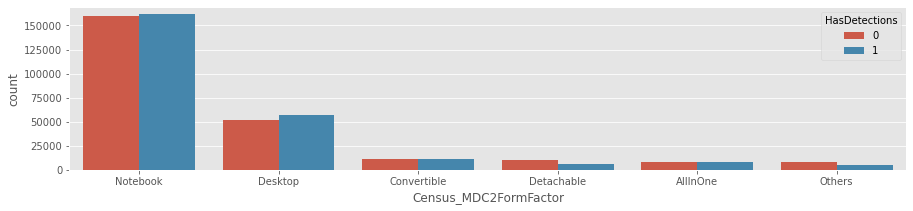

In [149]:
plt.figure(figsize=(15,3))
sns.countplot(data=df, x='Census_MDC2FormFactor', hue='HasDetections')

Parece que para los casos de **Notebook** y **Desktop** hay una ligera relación con la detección de malware en los equipos.

#### Census_DeviceFamily

En el tipo de familia de los modelos, nos aparecen datos con el 99% de los registros para **Windows.Desktop**. Este atributo no nos aportara mucha información por si solo, pero no lo vamos a eliminar por si en combinación resulta útil.

In [150]:
explore_values('Census_DeviceFamily', df, 'HasDetections')

,count,pct,mean_target
Windows.Desktop,499183,1.00,1.00
Windows.Server,816,0.00,1.00
Windows,1,0.00,nan


#### Census_OEMNameIdentifier

In [151]:
explore_values('Census_OEMNameIdentifier', df, 'HasDetections')

,count,pct,mean_target
54.00,1,0.00,1.00
"3,878.00",5,0.00,1.00
"3,890.00",2487,0.01,1.00
"3,889.00",15,0.00,1.00
"3,885.00",3,0.00,1.00
...,...,...,...
"5,971.00",1,0.00,nan
"6,046.00",1,0.00,nan
"6,075.00",1,0.00,nan
"6,140.00",1,0.00,nan


In [152]:
df['Census_OEMNameIdentifier'].value_counts(dropna=False, normalize=True).head(20)

2,668.00   0.14
2,102.00   0.12
1,443.00   0.11
2,206.00   0.10
585.00     0.10
525.00     0.09
4,589.00   0.03
4,730.00   0.03
1,980.00   0.03
4,142.00   0.02
4,490.00   0.02
4,909.00   0.02
3,035.00   0.02
3,150.00   0.01
nan        0.01
3,133.00   0.01
530.00     0.01
516.00     0.01
1,780.00   0.01
666.00     0.01
Name: Census_OEMNameIdentifier, dtype: float64

In [153]:
df['Census_OEMNameIdentifier'].fillna(value=-999, inplace=True)

In [154]:
df['Census_OEMNameIdentifier'] = set_others(df, 'Census_OEMNameIdentifier', 14)

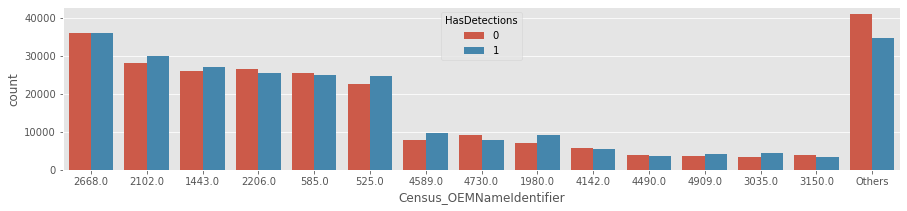

In [155]:
plt.figure(figsize=(15,3))
sns.countplot(data=df, x='Census_OEMNameIdentifier', hue='HasDetections')

Solo hay 3 casos en los que se ve una clara relación con el target: **2102, 1443, 1980**. En los demás la relación no es tan evidente.

#### Census_OEMModelIdentifier

In [156]:
explore_values('Census_OEMModelIdentifier', df, 'HasDetections')

,count,pct,mean_target
1.00,1,0.00,1.00
"272,108.00",3,0.00,1.00
"272,178.00",12,0.00,1.00
"272,176.00",2,0.00,1.00
"272,175.00",6,0.00,1.00
...,...,...,...
"345,371.00",1,0.00,nan
"345,387.00",1,0.00,nan
"345,421.00",1,0.00,nan
"345,473.00",1,0.00,nan


In [157]:
df['Census_OEMModelIdentifier'].value_counts(dropna=False).head(40)

313,586.00    17092
242,491.00    14726
317,701.00     7676
317,708.00     6541
nan            5764
228,975.00     4389
188,345.00     4063
241,876.00     3929
245,824.00     3815
244,755.00     2826
248,045.00     2496
313,507.00     2115
256,480.00     1954
241,805.00     1839
251,630.00     1682
171,320.00     1631
246,715.00     1622
241,911.00     1574
229,920.00     1535
228,726.00     1497
256,585.00     1493
313,506.00     1328
313,504.00     1283
248,395.00     1254
256,682.00     1248
229,929.00     1195
256,477.00     1172
256,581.00     1134
229,904.00     1111
256,588.00     1100
171,357.00     1081
171,222.00     1077
35,255.00      1054
171,210.00     1050
256,679.00     1019
331,205.00      977
170,875.00      973
328,142.00      954
256,685.00      947
189,551.00      941
Name: Census_OEMModelIdentifier, dtype: int64

In [158]:
df['Census_OEMModelIdentifier'].fillna(value=-999, inplace=True)

In [159]:
df['Census_OEMModelIdentifier'] = set_others(df, 'Census_OEMModelIdentifier', 20)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]),
 <a list of 21 Text major ticklabel objects>)

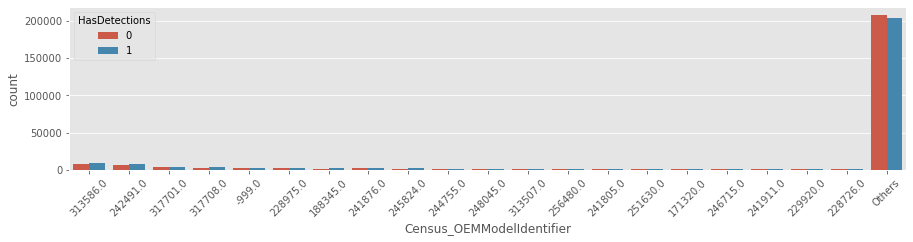

In [160]:
plt.figure(figsize=(15,3))
sns.countplot(data=df, x='Census_OEMModelIdentifier', hue='HasDetections')
plt.xticks(rotation=45)

#### Census_ProcessorCoreCount

En el caso de los nucleos de los procesadores, vemos como con 3 categorias abarcamos el 97% de los casos. Vamos a agrupar los resultados de los demás en Others.

In [161]:
df['Census_ProcessorCoreCount'].value_counts(dropna=False, normalize=True)

4.00    0.61
2.00    0.26
8.00    0.10
12.00   0.01
6.00    0.01
1.00    0.01
nan     0.00
16.00   0.00
3.00    0.00
32.00   0.00
20.00   0.00
24.00   0.00
40.00   0.00
28.00   0.00
36.00   0.00
48.00   0.00
10.00   0.00
5.00    0.00
56.00   0.00
7.00    0.00
11.00   0.00
64.00   0.00
80.00   0.00
52.00   0.00
14.00   0.00
88.00   0.00
44.00   0.00
46.00   0.00
Name: Census_ProcessorCoreCount, dtype: float64

In [162]:
df['Census_ProcessorCoreCount'].fillna(value=-999, inplace=True)

In [163]:
df['Census_ProcessorCoreCount'] = set_others(df, 'Census_ProcessorCoreCount', 3)

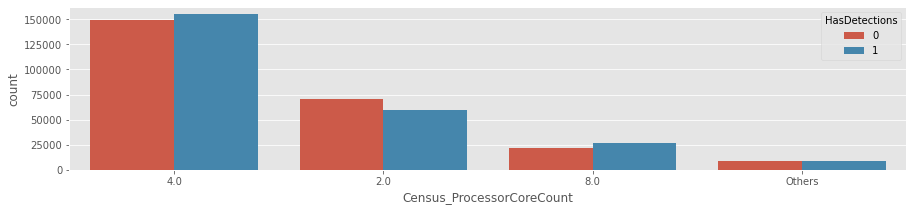

In [164]:
plt.figure(figsize=(15,3))
sns.countplot(data=df, x='Census_ProcessorCoreCount', hue='HasDetections')

#### Census_ProcessorManufacturerIdentifier

Para este atributo vemos como los resultados estan claramente agrupados en dos categorias: **5.00** y **1.00**. Vamos a agrupar los demás resultados en others.

In [165]:
explore_values('Census_ProcessorManufacturerIdentifier', df, 'HasDetections')

,count,pct,mean_target
1.00,58604,0.12,1.00
3.00,7,0.00,1.00
5.00,439028,0.88,1.00
10.00,14,0.00,nan


In [166]:
df['Census_ProcessorManufacturerIdentifier'].isnull().sum()

2347

In [167]:
df['Census_ProcessorManufacturerIdentifier'].fillna(value=-999, inplace=True)

In [168]:
df['Census_ProcessorManufacturerIdentifier'] = set_others(df, 'Census_ProcessorManufacturerIdentifier', 2)

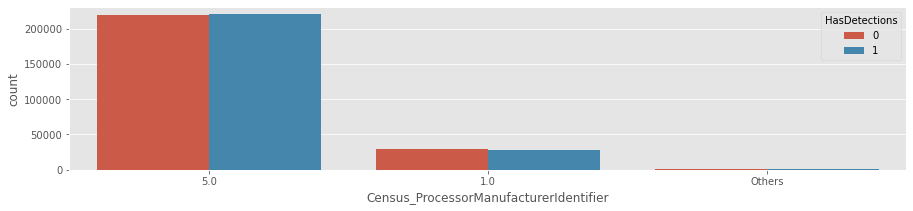

In [169]:
plt.figure(figsize=(15,3))
sns.countplot(data=df, x='Census_ProcessorManufacturerIdentifier', hue='HasDetections')

#### Census_ProcessorModelIdentifier

In [170]:
df['Census_ProcessorModelIdentifier'].value_counts(dropna=False, normalize=True).head(40)

2,697.00   0.03
1,998.00   0.03
2,660.00   0.02
2,373.00   0.02
1,992.00   0.02
2,382.00   0.02
2,640.00   0.02
2,097.00   0.01
1,985.00   0.01
1,848.00   0.01
2,737.00   0.01
1,916.00   0.01
3,063.00   0.01
2,321.00   0.01
2,574.00   0.01
3,082.00   0.01
2,412.00   0.01
3,026.00   0.01
2,523.00   0.01
2,569.00   0.01
3,397.00   0.01
2,393.00   0.01
3,038.00   0.01
2,525.00   0.01
3,394.00   0.01
2,296.00   0.01
2,302.00   0.01
3,104.00   0.01
2,998.00   0.01
2,706.00   0.01
2,407.00   0.01
3,499.00   0.01
3,396.00   0.01
1,984.00   0.01
2,329.00   0.01
1,914.00   0.01
2,535.00   0.01
288.00     0.01
2,908.00   0.00
2,503.00   0.00
Name: Census_ProcessorModelIdentifier, dtype: float64

In [171]:
df['Census_ProcessorModelIdentifier'].isnull().sum()

2349

In [172]:
df['Census_ProcessorModelIdentifier'].fillna(value=-999, inplace=True)

In [173]:
df['Census_ProcessorModelIdentifier'] = set_others(df, 'Census_ProcessorModelIdentifier', 40)

In [174]:
df.pivot_table(index='Census_OEMModelIdentifier', values='HasDetections', aggfunc=[len, np.sum, np.mean])

,len,sum,mean
,HasDetections,HasDetections,HasDetections
Census_OEMModelIdentifier,,,
313586.0,17092,9515,0.56
242491.0,14726,7661,0.52
317701.0,7676,4078,0.53
317708.0,6541,3529,0.54
-999.0,5764,2766,0.48
228975.0,4389,2196,0.50
188345.0,4063,2372,0.58
241876.0,3929,2081,0.53


Parece que para algunos casos podria tener una ligera relación positiva con el target, aunque la mayoria ronda el 50%.

#### Census_ProcessorClass

La clase de procesador parece que podria ser relevante para la detección de malware. El problema es que este atributo tiene muy pocos valores debido a la gran cantidad de nulos que tiene 99,9%.

In [175]:
df.pivot_table(index='Census_ProcessorClass', values='HasDetections', aggfunc=[len, np.sum, np.mean])

,len,sum,mean
,HasDetections,HasDetections,HasDetections
Census_ProcessorClass,,,
high,340,211,0.62
low,546,287,0.53
mid,1196,679,0.57


In [176]:
df['Census_ProcessorClass'].value_counts(dropna=False, normalize=True)

NaN    1.00
mid    0.00
low    0.00
high   0.00
Name: Census_ProcessorClass, dtype: float64

In [177]:
df['Census_ProcessorClass'].fillna(value=-999, inplace=True)

No lo vamos a eliminar porque por si solo ya parece ser relevante, igual al cruzarlo con otros atributos conseguimos aportar información relevante.

##### Census_PrimaryDiskTotalCapacity

La cantidad de espacio en el disco principal está reflajada en MB. Vemos como con los dos primeros casos ya tendriamos el 56% de los casos. Vamos a dejar los primeros 10 grupos y con el resto agruparremos sus resultados en la categoria Others.

In [178]:
df['Census_PrimaryDiskTotalCapacity'].value_counts(dropna=False, normalize=True).head(20)

476,940.00     0.32
953,869.00     0.24
305,245.00     0.05
122,104.00     0.05
244,198.00     0.05
238,475.00     0.04
29,820.00      0.03
114,473.00     0.03
715,404.00     0.03
228,936.00     0.02
152,627.00     0.01
1,907,729.00   0.01
488,386.00     0.01
59,640.00      0.01
29,824.00      0.01
610,480.00     0.01
nan            0.01
29,600.00      0.00
76,319.00      0.00
457,862.00     0.00
Name: Census_PrimaryDiskTotalCapacity, dtype: float64

In [179]:
df['Census_PrimaryDiskTotalCapacity'].fillna(value=-999, inplace=True)

In [180]:
df['Census_PrimaryDiskTotalCapacity'] = set_others(df, 'Census_PrimaryDiskTotalCapacity', 10)

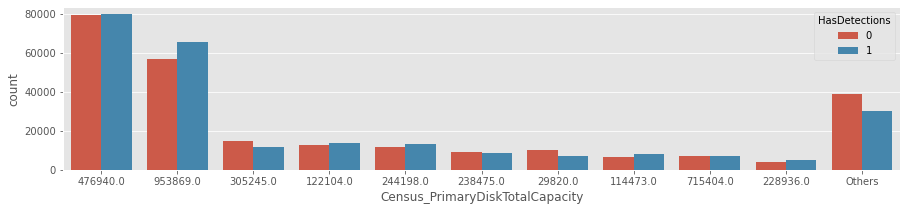

In [181]:
plt.figure(figsize=(15,3))
sns.countplot(data=df, x='Census_PrimaryDiskTotalCapacity', hue='HasDetections')

Vemos como en los casos que tienen una memoria en el disco principal de cercano a 1TB.

#### Census_PrimaryDiskTypeName

Los principales tipos de disco principal son **HDD** y **SSD**. Luego hay una cantidad importante de valor por los cuales no sabemos de que tipo son, se podrian considerar como nulos.

In [182]:
explore_values('Census_PrimaryDiskTypeName', df, 'HasDetections')

,count,pct,mean_target
Census_PrimaryDiskTypeName,,,
HDD,325429,0.65,1
SSD,138155,0.28,1
UNKNOWN,20083,0.04,1
Unspecified,15624,0.03,1


In [183]:
df['Census_PrimaryDiskTypeName'].fillna(value='UNKNOWN', inplace=True)

In [184]:
df[df['Census_PrimaryDiskTypeName'] == 'Unspecified'] = df[df['Census_PrimaryDiskTypeName'] == 'Unspecified'].replace('Unspecified','UNKNOWN')

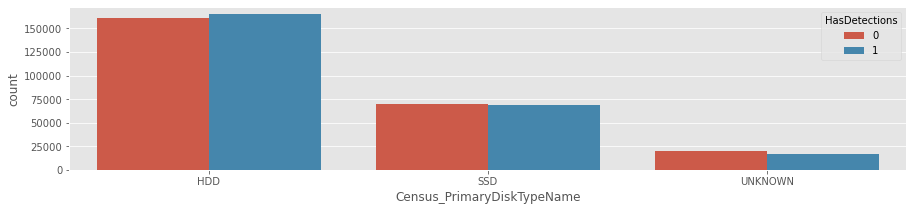

In [185]:
plt.figure(figsize=(15,3))
sns.countplot(data=df, x='Census_PrimaryDiskTypeName', hue='HasDetections')

#### Census_SystemVolumeTotalCapacity

Este atributo mide el volumen total del sistema en MB. Al ser una variable númerica, solo vamos a tratar los nulos.

In [186]:
df['Census_SystemVolumeTotalCapacity'].value_counts(dropna=False, normalize=True)

nan            0.01
28,542.00      0.01
926,992.00     0.01
476,389.00     0.00
476,324.00     0.00
               ... 
435,756.00     0.00
435,758.00     0.00
27,235.00      0.00
435,761.00     0.00
1,048,576.00   0.00
Name: Census_SystemVolumeTotalCapacity, Length: 142052, dtype: float64

In [187]:
df['Census_SystemVolumeTotalCapacity'].fillna(value=-999, inplace=True)

In [188]:
df['Census_SystemVolumeTotalCapacity'].value_counts(dropna=False, normalize=True).head(20)

-999.00      0.01
28,542.00    0.01
926,992.00   0.01
476,389.00   0.00
476,324.00   0.00
102,400.00   0.00
953,253.00   0.00
952,728.00   0.00
476,323.00   0.00
475,799.00   0.00
952,727.00   0.00
952,792.00   0.00
476,438.00   0.00
28,558.00    0.00
380,772.00   0.00
243,582.00   0.00
476,373.00   0.00
113,922.00   0.00
121,488.00   0.00
953,318.00   0.00
Name: Census_SystemVolumeTotalCapacity, dtype: float64

#### Census_HasOpticalDiskDrive

Este atributo nos informa sobre si la maquina tiene o no una unidad de disco óptico (CD / DVD). El 92% no tiene disco óptico.

In [189]:
explore_values('Census_HasOpticalDiskDrive', df, 'HasDetections')

,count,pct,mean_target
0,461483,0.92,1
1,38517,0.08,1


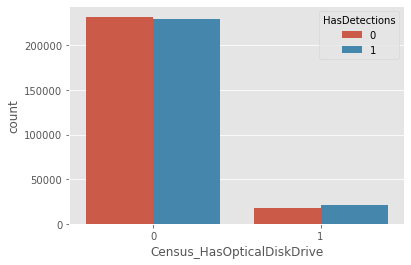

In [190]:
sns.countplot(data=df, x='Census_HasOpticalDiskDrive', hue='HasDetections')

En los equipos que si tienen disco óptico, parece haber una ligera relación con el target.

#### Census_TotalPhysicalRAM

Este atributo nos informa de la capicidad de memoria RAM en MB.

In [191]:
explore_values('Census_TotalPhysicalRAM', df, 'HasDetections')

,count,pct,mean_target
512.00,6,0.00,1.00
"8,191.00",110,0.00,1.00
"8,098.00",1,0.00,1.00
"8,099.00",2,0.00,1.00
"8,112.00",1,0.00,1.00
...,...,...,...
"102,400.00",1,0.00,nan
"114,688.00",1,0.00,nan
"196,608.00",4,0.00,nan
"229,376.00",1,0.00,nan


In [192]:
df['Census_TotalPhysicalRAM'].fillna(value=-999, inplace=True)

In [193]:
df['Census_TotalPhysicalRAM'].value_counts(dropna=False).head(10)

4,096.00     228678
8,192.00     123174
2,048.00      61694
16,384.00     30179
6,144.00      22349
12,288.00      9074
3,072.00       8468
-999.00        4556
1,024.00       3603
32,768.00      3308
Name: Census_TotalPhysicalRAM, dtype: int64

In [194]:
df['Census_TotalPhysicalRAM'] = set_others(df, 'Census_TotalPhysicalRAM', 5)

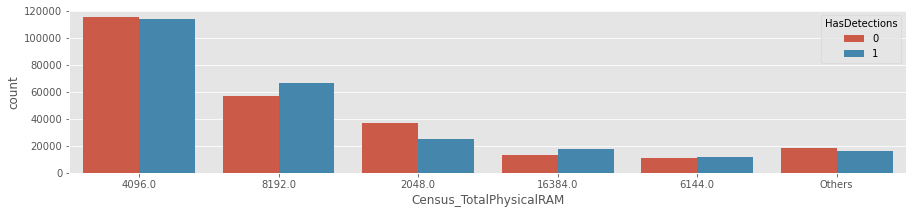

In [195]:
plt.figure(figsize=(15,3))
sns.countplot(data=df, x='Census_TotalPhysicalRAM', hue='HasDetections')

Como se puede ver en el gráfico anterior, hay una clara relación con el target en los casos de **8GB** de **RAM**

#### Census_ChassisTypeName

In [196]:
df['Census_ChassisTypeName'].value_counts(dropna=False, normalize=True)

Notebook              0.59
Desktop               0.21
Laptop                0.08
Portable              0.04
AllinOne              0.02
MiniTower             0.01
Convertible           0.01
Other                 0.01
UNKNOWN               0.01
Detachable            0.01
LowProfileDesktop     0.01
HandHeld              0.01
SpaceSaving           0.00
Tablet                0.00
Tower                 0.00
Unknown               0.00
MainServerChassis     0.00
MiniPC                0.00
LunchBox              0.00
RackMountChassis      0.00
SubNotebook           0.00
BusExpansionChassis   0.00
NaN                   0.00
30                    0.00
StickPC               0.00
0                     0.00
35                    0.00
Blade                 0.00
PizzaBox              0.00
MultisystemChassis    0.00
31                    0.00
SubChassis            0.00
25                    0.00
ExpansionChassis      0.00
32                    0.00
Name: Census_ChassisTypeName, dtype: float64

In [197]:
df['Census_ChassisTypeName'].fillna(value='Unknown', inplace=True)

In [198]:
df['Census_ChassisTypeName'] = set_others(df, 'Census_ChassisTypeName', 3)

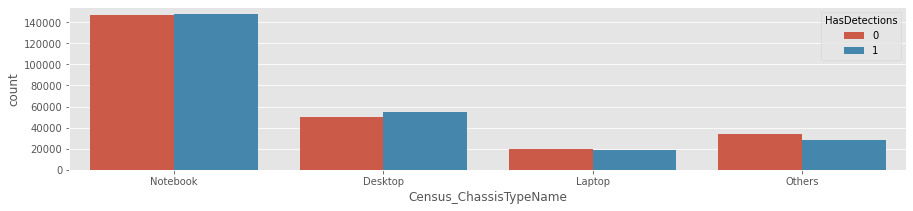

In [199]:
plt.figure(figsize=(15,3))
sns.countplot(data=df, x='Census_ChassisTypeName', hue='HasDetections')

##### Census_InternalPrimaryDiagonalDisplaySizeInInches

Este atributo nos informa de la longitud diagonal física en pulgadas de la pantalla principal. Al tratarse de una variable numérica, solo vamos a tratar los nulos.

In [200]:
df['Census_InternalPrimaryDiagonalDisplaySizeInInches'].value_counts(dropna=False, normalize=True)

15.50   0.34
13.90   0.11
14.00   0.06
11.60   0.04
21.50   0.03
        ... 
64.60   0.00
56.00   0.00
65.70   0.00
70.70   0.00
5.00    0.00
Name: Census_InternalPrimaryDiagonalDisplaySizeInInches, Length: 521, dtype: float64

In [201]:
df['Census_InternalPrimaryDiagonalDisplaySizeInInches'].isnull().sum()

2654

In [202]:
df['Census_InternalPrimaryDiagonalDisplaySizeInInches'].fillna(value=-999, inplace=True)

#### Census_InternalPrimaryDisplayResolutionHorizontal

Este atributo nos informa del número de píxeles en la dirección horizontal de la pantalla interna. Al tratarse de una variable numérica, solo vamos a tratar los nulos.

In [203]:
df['Census_InternalPrimaryDisplayResolutionHorizontal'].isnull().sum()

2650

In [204]:
df['Census_InternalPrimaryDisplayResolutionHorizontal'].fillna(value=-999, inplace=True)

#### Census_InternalPrimaryDisplayResolutionVertical

Este atributo nos informa del número de píxeles en la dirección vertical de la pantalla interna. Al tratarse de una variable numérica, solo vamos a tratar los nulos.

In [205]:
df['Census_InternalPrimaryDisplayResolutionVertical'].isnull().sum()

2650

In [206]:
df['Census_InternalPrimaryDisplayResolutionVertical'].fillna(value=-999, inplace=True)

#### Census_PowerPlatformRoleName

Esta variable nos indica el perfil de administración de energía preferido por el fabricante. Gracias a lo cual podemos saber el tipo de dispositivo.

In [207]:
df.pivot_table(index='Census_PowerPlatformRoleName', values='HasDetections', aggfunc=[len, np.sum, np.mean])

,len,sum,mean
,HasDetections,HasDetections,HasDetections
Census_PowerPlatformRoleName,,,
AppliancePC,212,46,0.22
Desktop,116054,60942,0.53
EnterpriseServer,406,177,0.44
Mobile,346378,173910,0.50
PerformanceServer,4,3,0.75
SOHOServer,2062,1024,0.50
Slate,27475,10082,0.37
UNKNOWN,1172,571,0.49


In [208]:
df['Census_PowerPlatformRoleName'].isnull().sum()

2

In [209]:
df['Census_PowerPlatformRoleName'].fillna(value='UNKNOWN', inplace=True)

In [210]:
df['Census_PowerPlatformRoleName'] = set_others(df, 'Census_PowerPlatformRoleName', 3)

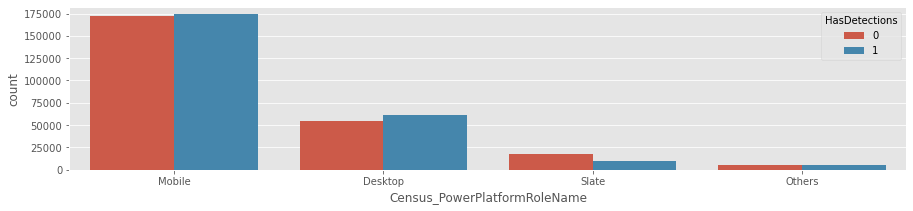

In [211]:
plt.figure(figsize=(15,3))
sns.countplot(data=df, x='Census_PowerPlatformRoleName', hue='HasDetections')

Podemos ver como hay una ligera relación con el target en los casos de **Mobile** y **Desktop**.

#### Census_InternalBatteryType

Podemos observar como el 70% de los valores son nulos.

In [212]:
explore_values('Census_InternalBatteryType', df, 'HasDetections')

,count,pct,mean_target
lion,113500,0.79,1.00
unkn,19,0.00,1.00
icp3,1,0.00,1.00
lgl0,1,0.00,1.00
a132,2,0.00,1.00
lipp,3,0.00,1.00
bad,3,0.00,1.00
ram,5,0.00,1.00
4cel,6,0.00,1.00
ithi,7,0.00,1.00


In [213]:
df['Census_InternalBatteryType'].isnull().sum()

355603

In [214]:
df['Census_InternalBatteryType'].fillna(value=-999, inplace=True)

In [215]:
df['Census_InternalBatteryType'].value_counts(dropna=False, normalize=True)

-999   0.71
lion   0.23
li-i   0.03
#      0.02
lip    0.01
liio   0.00
li p   0.00
li     0.00
nimh   0.00
real   0.00
bq20   0.00
pbac   0.00
vbox   0.00
lgi0   0.00
unkn   0.00
lipo   0.00
lhp0   0.00
ithi   0.00
4cel   0.00
ram    0.00
lipp   0.00
bad    0.00
batt   0.00
a132   0.00
virt   0.00
icp3   0.00
lgl0   0.00
li-l   0.00
3ion   0.00
Name: Census_InternalBatteryType, dtype: float64

In [216]:
df.pivot_table(index='Census_InternalBatteryType', values='HasDetections', aggfunc=[len, np.sum, np.mean])

,len,sum,mean
,HasDetections,HasDetections,HasDetections
Census_InternalBatteryType,,,
-999,355603,179829,0.51
#,10176,5321,0.52
3ion,1,0,0.00
4cel,6,1,0.17
a132,2,1,0.50
bad,3,1,0.33
batt,3,0,0.00
bq20,143,38,0.27


In [217]:
df['Census_InternalBatteryType'] = set_others(df, 'Census_InternalBatteryType', 4)

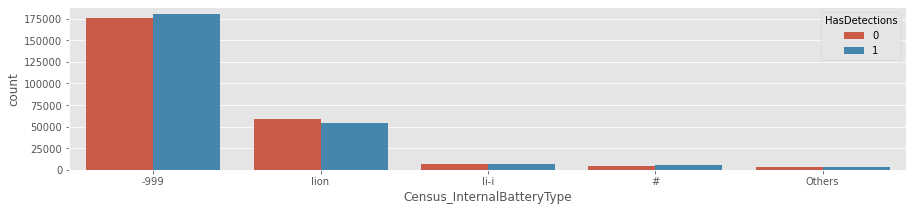

In [218]:
plt.figure(figsize=(15,3))
sns.countplot(data=df, x='Census_InternalBatteryType', hue='HasDetections')

#### Census_InternalBatteryNumberOfCharges

Estas variable nos informa del número de cargas de la batería interna. Al ser una variable numérica solo trataremos los nulos. 

In [219]:
df['Census_InternalBatteryNumberOfCharges'].value_counts(dropna=False, normalize=True).head(10)

0.00               0.57
4,294,967,295.00   0.25
nan                0.03
1.00               0.01
16.00              0.00
2.00               0.00
3.00               0.00
33.00              0.00
4.00               0.00
5.00               0.00
Name: Census_InternalBatteryNumberOfCharges, dtype: float64

In [220]:
df['Census_InternalBatteryNumberOfCharges'].fillna(value=-999, inplace=True)

In [221]:
df.pivot_table(index='Census_InternalBatteryNumberOfCharges', values='HasDetections', aggfunc=[len, np.sum, np.mean])

,len,sum,mean
,HasDetections,HasDetections,HasDetections
Census_InternalBatteryNumberOfCharges,,,
-999.00,15038,8012,0.53
0.00,283189,140772,0.50
1.00,2955,1235,0.42
2.00,1503,628,0.42
3.00,1212,510,0.42
...,...,...,...
"65,497.00",1,1,1.00
"65,504.00",1,1,1.00


De este atributo podemos sacar alguna información relevante, por ejemplo seguramente los dispositvos que estan a 0, son los que no se tienen que cargar. Es decir, los ordenadores tipo **Desktop**. Por otro lado, los dispositivos que se cargan tanto que vemos en el cuadro anterior seguramente se trate de dispositivos **Mobile**.

#### Census_OSArchitecture

Podemos observar como el 91% de los datos tienen un sistema operativo de **amd64**. Es decir, son ordenadores con SO anteriores a Windows10(**arm64**)

In [222]:
explore_values('Census_OSArchitecture', df, 'HasDetections')

,count,pct,mean_target
amd64,454435,0.91,1.00
x86,45551,0.09,1.00
arm64,14,0.00,nan


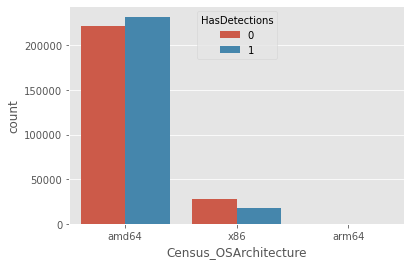

In [223]:
sns.countplot(data=df, x='Census_OSArchitecture', hue='HasDetections')

Al parecer para los SO amd64 si hay una relación con la detección de malware en los dispositivos.

#### Census_OSBranch

In [224]:
explore_values('Census_OSBranch', df, 'HasDetections')

,count,pct,mean_target
rs4_release,226001,0.45,1.00
rs3_release,69216,0.14,1.00
rs3_release_svc_escrow,67027,0.13,1.00
rs2_release,44264,0.09,1.00
rs1_release,43705,0.09,1.00
th2_release,18298,0.04,1.00
th2_release_sec,14895,0.03,1.00
th1_st1,10822,0.02,1.00
th1,4284,0.01,1.00
rs5_release,839,0.00,1.00


In [225]:
df['Census_OSBranch'] = set_others(df, 'Census_OSBranch', 5)

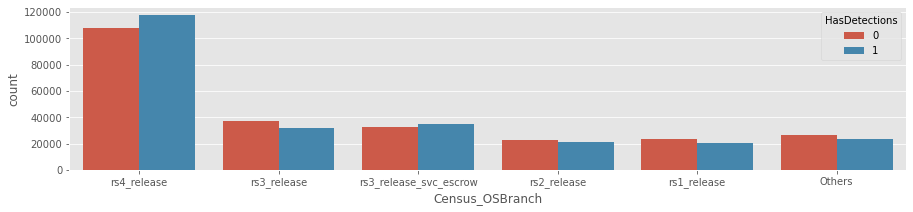

In [226]:
plt.figure(figsize=(15,3))
sns.countplot(data=df, x='Census_OSBranch', hue='HasDetections')

En el gráfico anterior podemos ver como para el **rs4_release** si parece tener una ligera relación con el target.

#### Census_OSBuildNumber

Este atributo, a pesar de ser numérico, si nod fijamos bien el 95% de sus registros estan agrupados en 6 diferentes tipos. Por lo que vamos a agrupar el resto en Others, así facilitaremos las cosas a nuestro modelo DT.

In [227]:
explore_values('Census_OSBuildNumber', df, 'HasDetections')

,count,pct,mean_target
10240,15106,0.03,1.00
17746,65,0.00,1.00
17686,34,0.00,1.00
17692,146,0.00,1.00
17713,8,0.00,1.00
17730,2,0.00,1.00
17733,35,0.00,1.00
17735,39,0.00,1.00
17738,165,0.00,1.00
17741,45,0.00,1.00


In [228]:
df['Census_OSBuildNumber'].value_counts(dropna=False, normalize=True)

17134   0.45
16299   0.27
15063   0.09
14393   0.09
10586   0.07
10240   0.03
17738   0.00
17692   0.00
17744   0.00
17758   0.00
17746   0.00
17763   0.00
17754   0.00
17751   0.00
17741   0.00
17755   0.00
17735   0.00
17733   0.00
17686   0.00
17760   0.00
17133   0.00
17682   0.00
17677   0.00
17672   0.00
18237   0.00
18234   0.00
18242   0.00
17661   0.00
17713   0.00
17666   0.00
17634   0.00
17747   0.00
17639   0.00
17655   0.00
17650   0.00
17730   0.00
14986   0.00
17074   0.00
17623   0.00
17618   0.00
14295   0.00
15048   0.00
18219   0.00
18214   0.00
17604   0.00
17723   0.00
15042   0.00
14328   0.00
15019   0.00
17749   0.00
16193   0.00
14926   0.00
9600    0.00
16251   0.00
11082   0.00
14971   0.00
17753   0.00
14421   0.00
14946   0.00
17004   0.00
17046   0.00
Name: Census_OSBuildNumber, dtype: float64

In [229]:
df['Census_OSBuildNumber'] = set_others(df, 'Census_OSBuildNumber', 6)

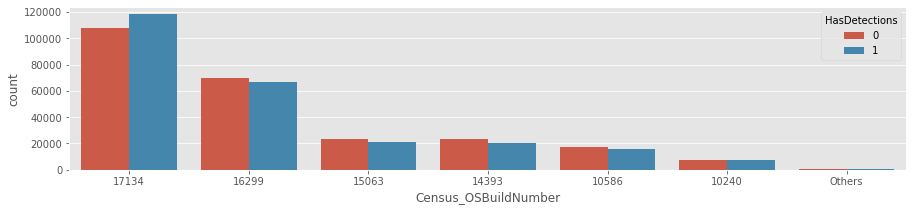

In [230]:
plt.figure(figsize=(15,3))
sns.countplot(data=df, x='Census_OSBuildNumber', hue='HasDetections')

Poder ver a partir del gráfico anterior como en el caso del BuildNumber 17134, si parece haber relación con la detección de malware.

#### Census_OSBuildRevision

Este atributo, igual que en el caso anterior, si nos fijamos bien podriamos agrupar con los primeros 10 tipos. 

In [231]:
df['Census_OSBuildRevision'].value_counts(dropna=False, normalize=True).head(30)

228     0.16
165     0.10
431     0.06
285     0.05
112     0.04
547     0.04
371     0.04
191     0.03
2189    0.02
611     0.02
125     0.02
17443   0.02
1176    0.02
492     0.02
0       0.02
309     0.02
286     0.02
15      0.01
254     0.01
1       0.01
1206    0.01
1266    0.01
192     0.01
167     0.01
137     0.01
248     0.01
48      0.01
1088    0.01
81      0.01
693     0.01
Name: Census_OSBuildRevision, dtype: float64

In [232]:
df['Census_OSBuildRevision'] = set_others(df, 'Census_OSBuildRevision', 10)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text major ticklabel objects>)

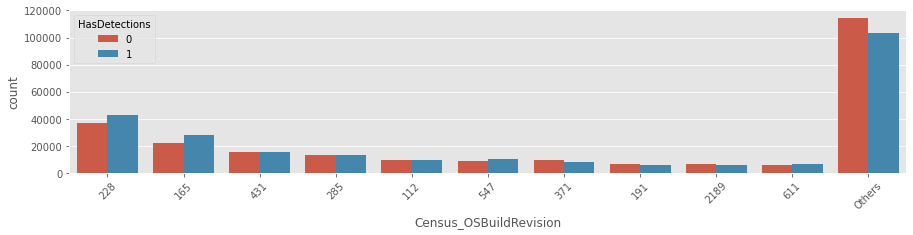

In [233]:
plt.figure(figsize=(15,3))
sns.countplot(data=df, x='Census_OSBuildRevision', hue='HasDetections')
plt.xticks(rotation=45)

#### Census_OSEdition

Para la edición del sistema operativo, hay principalmente 3 categorias con los que se explica el 95% de los casos. Vamos a agrupar el resto en la categoria other. 

In [234]:
explore_values('Census_OSEdition', df, 'HasDetections')

,count,pct,mean_target
Core,194469,0.39,1.00
CoreN,251,0.00,1.00
ProfessionalWorkstation,2,0.00,1.00
ProfessionalEducationN,12,0.00,1.00
EnterpriseN,28,0.00,1.00
ServerSolution,34,0.00,1.00
EnterpriseSN,47,0.00,1.00
ServerDatacenterEval,47,0.00,1.00
EducationN,61,0.00,1.00
ServerStandardEval,151,0.00,1.00


In [235]:
df['Census_OSEdition'] = set_others(df, 'Census_OSEdition', 3)

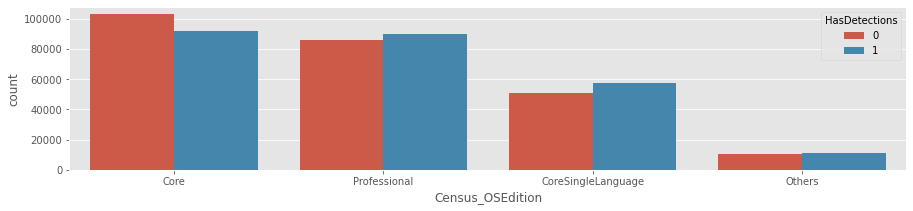

In [236]:
plt.figure(figsize=(15,3))
sns.countplot(data=df, x='Census_OSEdition', hue='HasDetections')

#### Census_OSSkuName

Para este atributo, si nos fijamos bien podemos ver como claramente hay 3 categorias que explican el 97% de los casos. Vamos a agrupar el resto en others.

In [237]:
explore_values('Census_OSSkuName', df, 'HasDetections')

,count,pct,mean_target
CORE,194464,0.39,1.00
PROFESSIONAL,178947,0.36,1.00
PRO_WORKSTATION_N,1,0.00,1.00
PRO_WORKSTATION,2,0.00,1.00
ENTERPRISE_N,28,0.00,1.00
SB_SOLUTION_SERVER,34,0.00,1.00
DATACENTER_EVALUATION_SERVER,47,0.00,1.00
ENTERPRISE_S_N,48,0.00,1.00
EDUCATION_N,61,0.00,1.00
STANDARD_EVALUATION_SERVER,151,0.00,1.00


In [238]:
df['Census_OSSkuName'] = set_others(df, 'Census_OSSkuName', 3)

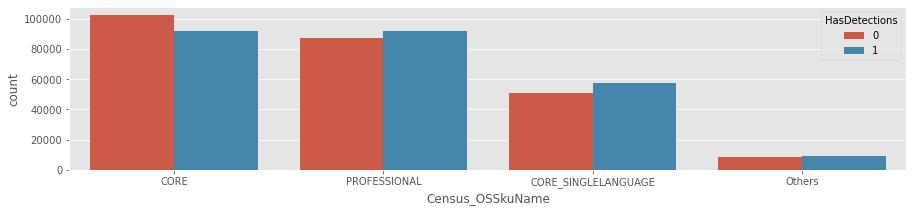

In [239]:
plt.figure(figsize=(15,3))
sns.countplot(data=df, x='Census_OSSkuName', hue='HasDetections')

En el gráfico anterior podemos ver como en las categorias **PROFESSIONAL** y **CORE_SINGLELANGUAGE** si que hay una ligera relación con la detección de malware

#### Census_OSInstallTypeName

Si nos fijamos, hay 4 tipos con los que abarcamos el 80% de los casos. Vamos a agrupar el resto en Others. 

In [240]:
explore_values('Census_OSInstallTypeName', df, 'HasDetections')

,count,pct,mean_target
UUPUpgrade,146780,0.29,1
IBSClean,92403,0.18,1
Update,88892,0.18,1
Upgrade,70013,0.14,1
Other,46960,0.09,1
Reset,36510,0.07,1
Refresh,11540,0.02,1
Clean,3885,0.01,1
CleanPCRefresh,3017,0.01,1


In [241]:
df['Census_OSInstallTypeName'] = set_others(df, 'Census_OSInstallTypeName', 4)

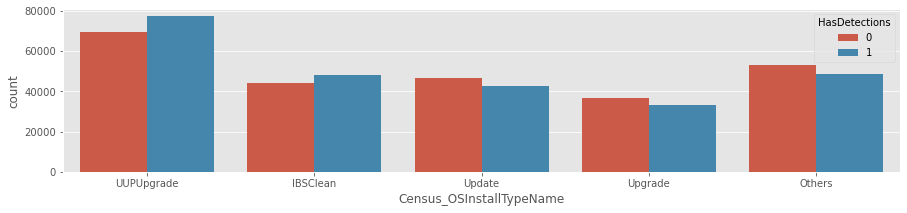

In [242]:
plt.figure(figsize=(15,3))
sns.countplot(data=df, x='Census_OSInstallTypeName', hue='HasDetections')

Podemos observar como para los casos como **UUPUpgrade** y **IBSClean** hay una ligera relación con el target.

#### Census_OSInstallLanguageIdentifier

In [243]:
explore_values('Census_OSInstallLanguageIdentifier', df, 'HasDetections')

,count,pct,mean_target
1.00,4516,0.01,1
30.00,1793,0.00,1
23.00,1652,0.00,1
24.00,8127,0.02,1
25.00,7502,0.02,1
26.00,18520,0.04,1
27.00,5956,0.01,1
28.00,713,0.00,1
29.00,27669,0.06,1
31.00,1213,0.00,1


In [244]:
df['Census_OSInstallLanguageIdentifier'].isnull().sum()

3332

In [245]:
df['Census_OSInstallLanguageIdentifier'].fillna(value=-999, inplace=True)

In [246]:
df['Census_OSInstallLanguageIdentifier'].value_counts(dropna=False, normalize=True)

8.00      0.36
9.00      0.12
7.00      0.06
29.00     0.06
14.00     0.05
37.00     0.05
10.00     0.04
26.00     0.04
5.00      0.03
35.00     0.02
39.00     0.02
18.00     0.02
20.00     0.02
24.00     0.02
25.00     0.02
27.00     0.01
19.00     0.01
17.00     0.01
1.00      0.01
3.00      0.01
-999.00   0.01
6.00      0.01
33.00     0.01
15.00     0.00
4.00      0.00
30.00     0.00
23.00     0.00
31.00     0.00
12.00     0.00
2.00      0.00
36.00     0.00
16.00     0.00
28.00     0.00
34.00     0.00
13.00     0.00
21.00     0.00
32.00     0.00
11.00     0.00
38.00     0.00
22.00     0.00
Name: Census_OSInstallLanguageIdentifier, dtype: float64

In [247]:
df['Census_OSInstallLanguageIdentifier'] = set_others(df, 'Census_OSInstallLanguageIdentifier', 10)

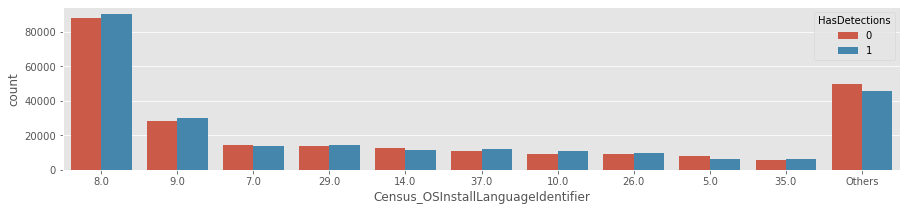

In [248]:
plt.figure(figsize=(15,3))
sns.countplot(data=df, x='Census_OSInstallLanguageIdentifier', hue='HasDetections')

De el gráfico anterior podemos ver como el lenguage de instalación más utilizado es el **8**. Posiblemente sea el idoma inglés.

#### Census_OSUILocaleIdentifier

In [249]:
explore_values('Census_OSUILocaleIdentifier', df, 'HasDetections')

,count,pct,mean_target
5,4599,0.01,1.00
109,8143,0.02,1.00
123,718,0.00,1.00
122,2,0.00,1.00
121,4,0.00,1.00
120,5993,0.01,1.00
119,18696,0.04,1.00
116,4,0.00,1.00
115,7496,0.01,1.00
105,1654,0.00,1.00


In [250]:
df['Census_OSUILocaleIdentifier'] = set_others(df, 'Census_OSUILocaleIdentifier', 10)

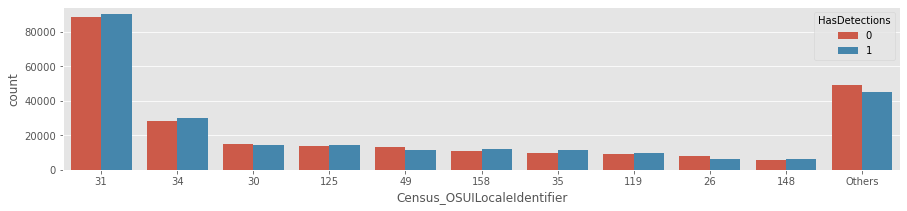

In [251]:
plt.figure(figsize=(15,3))
sns.countplot(data=df, x='Census_OSUILocaleIdentifier', hue='HasDetections')

Podemos ver como la region con más equipos es la **31**. Posiblemente se trate de una region de habla inglesa, debido a la información que hemos extraido anteriormente.

#### Census_OSWUAutoUpdateOptionsName

Para este atributo los datos estan concentrados en 3 categorias. Vamos a agrupar el resto en Others.

In [252]:
explore_values('Census_OSWUAutoUpdateOptionsName', df, 'HasDetections')

,count,pct,mean_target
FullAuto,222482,0.44,1
UNKNOWN,140961,0.28,1
Notify,113507,0.23,1
AutoInstallAndRebootAtMaintenanceTime,20731,0.04,1
Off,1506,0.00,1
DownloadNotify,813,0.00,1


In [253]:
df['Census_OSWUAutoUpdateOptionsName'] = set_others(df, 'Census_OSWUAutoUpdateOptionsName', 3)

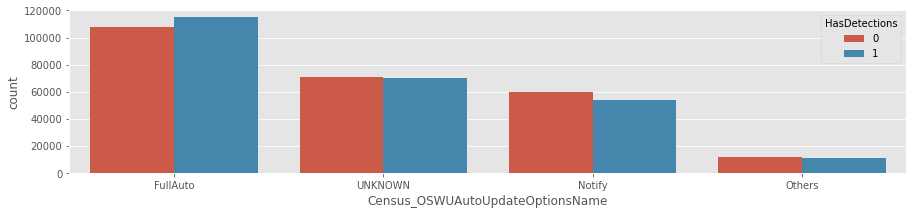

In [254]:
plt.figure(figsize=(15,3))
sns.countplot(data=df, x='Census_OSWUAutoUpdateOptionsName', hue='HasDetections')

Se observa como en el caso de la categoria **FullAuto** hay una ligera relación con el target.

#### Census_IsPortableOperatingSystem

Esta variable no informa sobre si el sistema operativo se inicia y se ejecuta a través de Windows-To-Go en una memoria USB. Como cabría esperar practicamente en todos los casos no es así.

In [255]:
explore_values('Census_IsPortableOperatingSystem', df, 'HasDetections')

,count,pct,mean_target
0,499739,1.00,1
1,261,0.00,1


In [256]:
df.pivot_table(index='Census_IsPortableOperatingSystem', values='HasDetections', aggfunc=[len, np.sum, np.mean])

,len,sum,mean
,HasDetections,HasDetections,HasDetections
Census_IsPortableOperatingSystem,,,
0,499739,249818,0.50
1,261,135,0.52


A pesar de no aportar mucho este atributo, no lo vamos a eliminar por si en cambinación con otros nos aporta información. Además como utilizaremos un DT, el propio modelo ya se encargara de descartarlo si es necesario

#### Census_GenuineStateName

In [257]:
explore_values('Census_GenuineStateName', df, 'HasDetections')

,count,pct,mean_target
IS_GENUINE,441402,0.88,1
INVALID_LICENSE,44990,0.09,1
OFFLINE,12834,0.03,1
UNKNOWN,774,0.00,1


In [258]:
df['Census_GenuineStateName'].isnull().sum()

0

#### Census_ActivationChannel

Podemos ver como el 90% de los datos están en dos categorias: **Retail** y **OEM:DM**. A pesar de ello, como hay pocas categorias no las vamos a agrupar y haremos un OHE.

In [259]:
explore_values('Census_ActivationChannel', df, 'HasDetections')

,count,pct,mean_target
Retail,264932,0.53,1
OEM:DM,191350,0.38,1
Volume:GVLK,25109,0.05,1
OEM:NONSLP,17943,0.04,1
Volume:MAK,468,0.00,1
Retail:TB:Eval,198,0.00,1


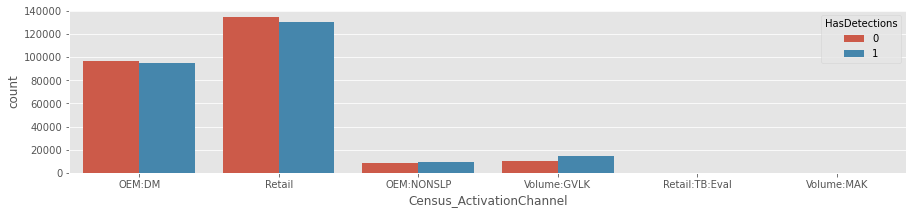

In [260]:
plt.figure(figsize=(15,3))
sns.countplot(data=df, x='Census_ActivationChannel', hue='HasDetections')

#### Census_IsFlightingInternal

Nos falta información acerca de este atributo. Además tiene un 83% de nulos. Vamos a tratar los nulos y a dejar que el DT decida, antes de eliminarlo.

In [261]:
explore_values('Census_IsFlightingInternal', df, 'HasDetections')

,count,pct,mean_target
0.00,84773,1.00,1
1.00,2,0.00,1


In [262]:
df.pivot_table(index='Census_IsFlightingInternal', values='HasDetections', aggfunc=[len, np.sum, np.mean])

,len,sum,mean
,HasDetections,HasDetections,HasDetections
Census_IsFlightingInternal,,,
0.00,84773,41101,0.48
1.00,2,1,0.50


In [263]:
df['Census_IsFlightingInternal'].fillna(value=-999, inplace=True)

In [264]:
df['Census_IsFlightingInternal'].value_counts(dropna=False, normalize=True)

-999.00   0.83
0.00      0.17
1.00      0.00
Name: Census_IsFlightingInternal, dtype: float64

#### Census_IsFlightsDisabled

In [265]:
df['Census_IsFlightsDisabled'].value_counts(dropna=False, normalize=True)

0.00   0.98
nan    0.02
1.00   0.00
Name: Census_IsFlightsDisabled, dtype: float64

In [266]:
df['Census_IsFlightsDisabled'].fillna(value=-999, inplace=True)

#### Census_FlightRing

Vemos como el 94% de los datos correponden a la categoria **Retail**. Vamos a agrupar todos los demás en Others.

In [267]:
explore_values('Census_FlightRing', df, 'HasDetections')

,count,pct,mean_target
Retail,468299,0.94,1.00
NOT_SET,16044,0.03,1.00
Unknown,13701,0.03,1.00
WIS,606,0.00,1.00
RP,583,0.00,1.00
WIF,549,0.00,1.00
Disabled,217,0.00,1.00
OSG,1,0.00,nan


In [268]:
df['Census_FlightRing'] = set_others(df, 'Census_FlightRing', 1)

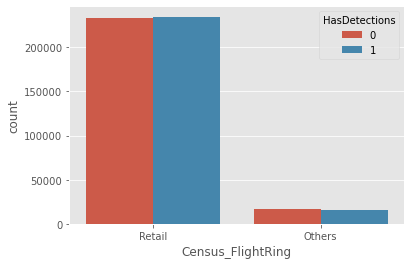

In [269]:
sns.countplot(data=df, x='Census_FlightRing', hue='HasDetections')

#### Census_ThresholdOptIn

Nos falta información acerca de esta variable. Además tiene un 64% de valores nulos. Vamos a tratar los nulos y al ser de tipo booleano no vamos a hacer nada más. Que el modelo decida.

In [270]:
explore_values('Census_ThresholdOptIn', df, 'HasDetections')

,count,pct,mean_target
0.00,181849,1.00,1
1.00,47,0.00,1


In [271]:
df['Census_ThresholdOptIn'].fillna(value=-999, inplace=True)

In [272]:
explore_values('Census_ThresholdOptIn', df, 'HasDetections')

,count,pct,mean_target
-999.00,318104,0.64,1
0.00,181849,0.36,1
1.00,47,0.00,1


#### Census_FirmwareManufacturerIdentifier

Para este atributo con los primeros 5 valores tenemos el 77% de los casos. Vamos a agrupar el resto en Others.

In [273]:
df['Census_FirmwareManufacturerIdentifier'].value_counts(dropna=False, normalize=True).head(10)

142.00   0.30
628.00   0.14
554.00   0.13
355.00   0.11
556.00   0.09
500.00   0.04
93.00    0.02
nan      0.02
807.00   0.02
513.00   0.02
Name: Census_FirmwareManufacturerIdentifier, dtype: float64

In [274]:
df['Census_FirmwareManufacturerIdentifier'].fillna(value=-999, inplace=True)

In [275]:
df['Census_FirmwareManufacturerIdentifier'] = set_others(df, 'Census_FirmwareManufacturerIdentifier', 5)

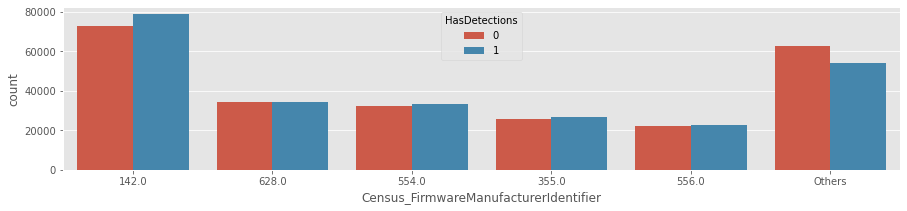

In [276]:
plt.figure(figsize=(15,3))
sns.countplot(data=df, x='Census_FirmwareManufacturerIdentifier', hue='HasDetections')

Vemos como para el fabricante **142** si parece haber una relación con la detección de malware.

#### Census_FirmwareVersionIdentifier

Para la version de Firmware, si observamos puede haber una forma de agrupar los valores por los primeros 2 dígitos.

In [277]:
df['Census_FirmwareVersionIdentifier'].value_counts(dropna=False, normalize=True).head(10)

nan         0.02
33,105.00   0.01
33,111.00   0.01
33,054.00   0.01
33,108.00   0.01
63,175.00   0.01
11,778.00   0.01
33,115.00   0.01
63,155.00   0.01
33,060.00   0.01
Name: Census_FirmwareVersionIdentifier, dtype: float64

In [278]:
df['Census_FirmwareVersionIdentifier'].fillna(value=-999, inplace=True)

In [279]:
df['Census_FirmwareVersionIdentifier'] = df['Census_FirmwareVersionIdentifier'].astype(str) 

In [280]:
df['Census_FirmwareVersionIdentifier'] = df['Census_FirmwareVersionIdentifier'].str.slice(stop=2)

In [281]:
df['Census_FirmwareVersionIdentifier'] = set_others(df, 'Census_FirmwareVersionIdentifier', 10)

In [282]:
df['Census_FirmwareVersionIdentifier'].value_counts(dropna=False, normalize=True)

Others   0.51
33       0.18
63       0.08
19       0.05
12       0.03
69       0.03
70       0.03
20       0.03
52       0.02
11       0.02
64       0.02
Name: Census_FirmwareVersionIdentifier, dtype: float64

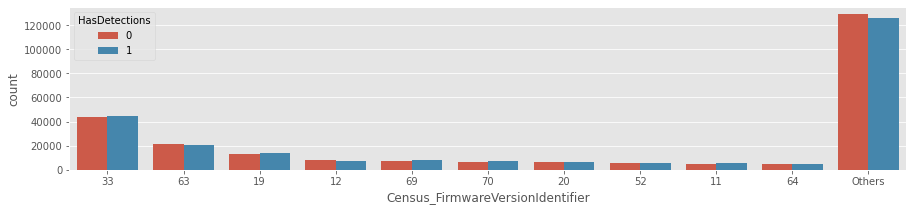

In [283]:
plt.figure(figsize=(15,3))
sns.countplot(data=df, x='Census_FirmwareVersionIdentifier', hue='HasDetections')

#### Census_IsSecureBootEnabled

Este atributo indica si el modo de arranque seguro está habilitado. Al parecer los resultados están al 50%. En combinación con otros atributos es posible que aporte información valiosa.

In [284]:
explore_values('Census_IsSecureBootEnabled', df, 'HasDetections')

,count,pct,mean_target
0,257281,0.51,1
1,242719,0.49,1


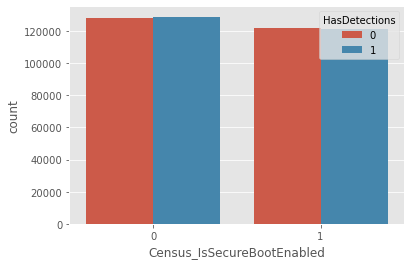

In [285]:
sns.countplot(data=df, x='Census_IsSecureBootEnabled', hue='HasDetections')

#### Census_IsVirtualDevice

Este atributo identifica una máquina virtual. El 99% de los datos no lo son. Quizás en combinación con otra variable aporta información valiosa. 

In [286]:
explore_values('Census_IsVirtualDevice', df, 'HasDetections')

,count,pct,mean_target
0.00,495572,0.99,1
1.00,3527,0.01,1


In [287]:
df['Census_IsVirtualDevice'].isnull().sum()

901

In [288]:
df['Census_IsVirtualDevice'].fillna(value=0, inplace=True)

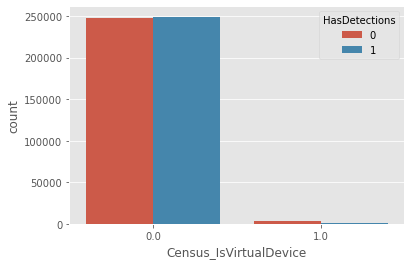

In [289]:
sns.countplot(data=df, x='Census_IsVirtualDevice', hue='HasDetections')

#### Census_IsTouchEnabled

Este atributo nos informa acerca de si un dispositivo táctil, o no. El 87% de ellos no lo es.

In [290]:
explore_values('Census_IsTouchEnabled', df, 'HasDetections')

,count,pct,mean_target
0,437283,0.87,1
1,62717,0.13,1


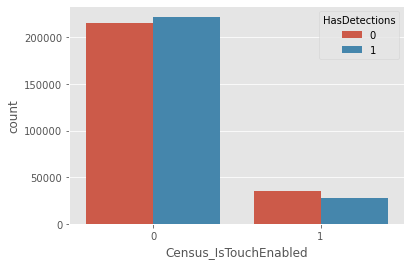

In [291]:
sns.countplot(data=df, x='Census_IsTouchEnabled', hue='HasDetections')

Parece que hay una ligera relación con el target en aquellos dispositivos que no son táctiles.

#### Census_IsPenCapable

Este atributo no informa sobre si el dispositivo tiene entrada USB. Esto puede ser importante en algunos casos ya que es una manera muy sencilla de introducir un virus en un dispositivo.

In [292]:
explore_values('Census_IsPenCapable', df, 'HasDetections')

,count,pct,mean_target
0,481128,0.96,1
1,18872,0.04,1


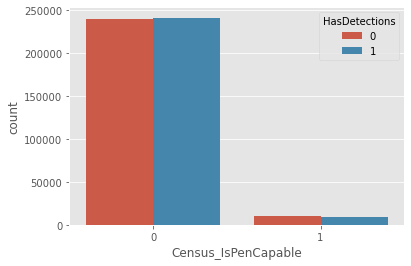

In [293]:
sns.countplot(data=df, x='Census_IsPenCapable', hue='HasDetections')

No parece tener mucha relación con el target por si solo, aunque quizás em combinación con otros atributos aporta información importante.

#### Census_IsAlwaysOnAlwaysConnectedCapable

Este atributo no informa acerca de si la batería permite que el dispositivo esté Siempre encendido y/o Siempre conectado. Al parecer el 94% de los dispositivos no lo permite.

In [294]:
explore_values('Census_IsAlwaysOnAlwaysConnectedCapable', df, 'HasDetections')

,count,pct,mean_target
0.00,467569,0.94,1
1.00,28391,0.06,1


In [295]:
df['Census_IsAlwaysOnAlwaysConnectedCapable'].fillna(value=0, inplace=True)

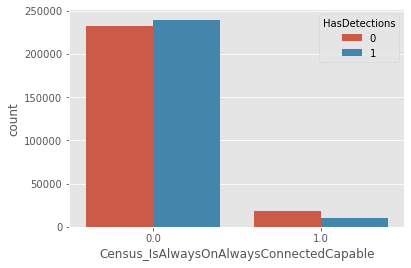

In [296]:
sns.countplot(data=df, x='Census_IsAlwaysOnAlwaysConnectedCapable', hue='HasDetections')

Parece tener una pequeña relación con el target, en los dispositivos que no tienen habilitado esta opción.

#### Wdft_IsGamer

Este atributo nos indica si el dispositivo es un dispositivo de Gamer o no según su combinación de hardware. Esto puede ser relevante ya que quizás se descarguen más cosas que juegos, etc. Y puede ser una vía de entrada para el malware.

In [297]:
explore_values('Wdft_IsGamer', df, 'HasDetections')

,count,pct,mean_target
0.00,345835,0.72,1
1.00,137215,0.28,1


In [298]:
df['Wdft_IsGamer'].fillna(value=0, inplace=True)

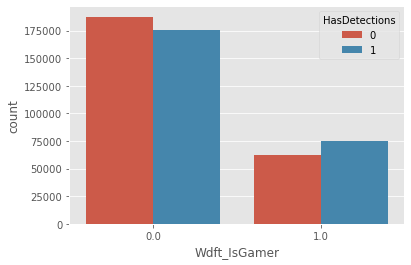

In [299]:
sns.countplot(data=df, x='Wdft_IsGamer', hue='HasDetections')

Como era de esperar, el gráfico muestra una clara relación de los dispositvos **Gamer** con el target.

#### Wdft_RegionIdentifier

Podemos ver como con 4 regiones se engloba el 70% de los datos prácticamente. Por lo que vamos a agrupar los demás resultados en others.

In [300]:
explore_values('Wdft_RegionIdentifier', df, 'HasDetections')

,count,pct,mean_target
1.00,68692,0.14,1
2.00,4470,0.01,1
3.00,73069,0.15,1
4.00,7586,0.02,1
5.00,11466,0.02,1
6.00,8750,0.02,1
7.00,33362,0.07,1
8.00,15761,0.03,1
9.00,4521,0.01,1
10.00,100392,0.21,1


In [301]:
df['Wdft_RegionIdentifier'].fillna(value=-999, inplace=True)

In [302]:
explore_values('Wdft_RegionIdentifier', df, 'HasDetections')

,count,pct,mean_target
-999.00,16950,0.03,1
1.00,68692,0.14,1
2.00,4470,0.01,1
3.00,73069,0.15,1
4.00,7586,0.02,1
5.00,11466,0.02,1
6.00,8750,0.02,1
7.00,33362,0.07,1
8.00,15761,0.03,1
9.00,4521,0.01,1


In [303]:
df['Wdft_RegionIdentifier'] = set_others(df, 'Wdft_RegionIdentifier', 4)

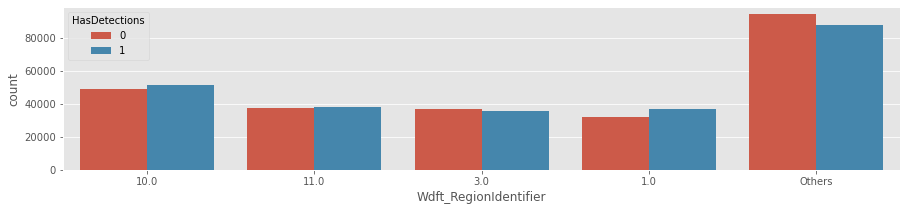

In [304]:
plt.figure(figsize=(15,3))
sns.countplot(data=df, x='Wdft_RegionIdentifier', hue='HasDetections')

### Final DF

In [305]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 500000 entries, f1cd864e97bae82bdf96523e1a539121 to 7b45dc3537e17f16305c5983ca0a1cb9
Data columns (total 77 columns):
 #   Column                                             Non-Null Count   Dtype   
---  ------                                             --------------   -----   
 0   ProductName                                        500000 non-null  object  
 1   EngineVersion                                      500000 non-null  int32   
 2   AppVersion                                         500000 non-null  category
 3   AvSigVersion                                       500000 non-null  category
 4   IsBeta                                             500000 non-null  int64   
 5   RtpStateBitfield                                   500000 non-null  category
 6   IsSxsPassiveMode                                   500000 non-null  int64   
 7   DefaultBrowsersIdentifier                          500000 non-null  category
 8   AVProductSta

In [306]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ProductName,500000,3,win8defender,494604,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EngineVersion,"500,000.00",NaN,NaN,NaN,"11,150,760.13","2,744.51","11,104,010.00","11,151,001.00","11,151,001.00","11,152,001.00","11,153,006.00"
AppVersion,500000,11,4.18.1807.18075,288809,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AvSigVersion,500000,12,1.275,219654,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IsBeta,"500,000.00",NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,1.00
RtpStateBitfield,"500,000.00",3.00,7.00,"484,841.00",NaN,NaN,NaN,NaN,NaN,NaN,NaN
IsSxsPassiveMode,"500,000.00",NaN,NaN,NaN,0.02,0.13,0.00,0.00,0.00,0.00,1.00
DefaultBrowsersIdentifier,"500,000.00",7.00,-999.00,"475,939.00",NaN,NaN,NaN,NaN,NaN,NaN,NaN
AVProductStatesIdentifier,"500,000.00",14.00,"53,447.00","326,463.00",NaN,NaN,NaN,NaN,NaN,NaN,NaN
AVProductsInstalled,"500,000.00",NaN,NaN,NaN,-2.55,62.16,-999.00,1.00,1.00,2.00,5.00


In [307]:
df.describe(include=np.number).T

,count,mean,std,min,25%,50%,75%,max
EngineVersion,"500,000.00","11,150,760.13","2,744.51","11,104,010.00","11,151,001.00","11,151,001.00","11,152,001.00","11,153,006.00"
IsBeta,"500,000.00",0.00,0.00,0.00,0.00,0.00,0.00,1.00
IsSxsPassiveMode,"500,000.00",0.02,0.13,0.00,0.00,0.00,0.00,1.00
AVProductsInstalled,"500,000.00",-2.55,62.16,-999.00,1.00,1.00,2.00,5.00
AVProductsEnabled,"500,000.00",-2.86,62.14,-999.00,1.00,1.00,1.00,4.00
HasTpm,"500,000.00",0.99,0.11,0.00,1.00,1.00,1.00,1.00
IsProtected,"500,000.00",0.95,0.23,0.00,1.00,1.00,1.00,1.00
Firewall,"500,000.00",0.98,0.15,0.00,1.00,1.00,1.00,1.00
UacLuaenable,"500,000.00",0.99,0.08,0.00,1.00,1.00,1.00,2.00
Census_SystemVolumeTotalCapacity,"500,000.00","375,798.51","338,720.63",-999.00,"120,539.75","248,585.50","475,968.00","47,687,100.00"


In [308]:
df.describe(exclude=np.number).T

,count,unique,top,freq
ProductName,500000,3,win8defender,494604
AppVersion,500000,11,4.18.1807.18075,288809
AvSigVersion,500000,12,1.275,219654
RtpStateBitfield,"500,000.00",3.00,7.00,"484,841.00"
DefaultBrowsersIdentifier,"500,000.00",7.00,-999.00,"475,939.00"
AVProductStatesIdentifier,"500,000.00",14.00,"53,447.00","326,463.00"
CountryIdentifier,500000,51,Others,107111
CityIdentifier,500000,21,Others,421134
OrganizationIdentifier,"500,000.00",3.00,27.00,"234,885.00"
GeoNameIdentifier,500000,31,Others,109329


Eliminanos la columna **HasDetections** ya que antes hemos creado la columna target y el tener las dos nos provocaria provacando que acertaramos siempre, ya que el modelo ya sabria la solución

In [309]:
df.drop('HasDetections', axis=1, inplace=True)

### OHE for Categorical Columns

In [310]:
def generate_dummies(dataframe, variable_name):
    _dummy_dataset = pd.get_dummies(dataframe[variable_name], prefix=variable_name)
    dataframe = pd.concat([dataframe, _dummy_dataset], axis=1)
    dataframe.drop(variable_name, axis=1, inplace=True)
    return dataframe

In [311]:
for column in df.select_dtypes(exclude=np.number).columns:
    df = generate_dummies(df, column)

In [312]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 500000 entries, f1cd864e97bae82bdf96523e1a539121 to 7b45dc3537e17f16305c5983ca0a1cb9
Columns: 498 entries, EngineVersion to Wdft_RegionIdentifier_Others
dtypes: float64(16), int32(2), int64(8), uint8(472)
memory usage: 344.2+ MB


### Modelling

In [313]:
X = df.drop('Target', axis=1)
y = df[['Target']]

In [314]:
X.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 500000 entries, f1cd864e97bae82bdf96523e1a539121 to 7b45dc3537e17f16305c5983ca0a1cb9
Columns: 497 entries, EngineVersion to Wdft_RegionIdentifier_Others
dtypes: float64(16), int32(1), int64(8), uint8(472)
memory usage: 342.3+ MB


In [315]:
y.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 500000 entries, f1cd864e97bae82bdf96523e1a539121 to 7b45dc3537e17f16305c5983ca0a1cb9
Columns: 1 entries, Target to Target
dtypes: int32(1)
memory usage: 25.7+ MB


In [316]:
X_dev, X_val, y_dev, y_val = model_selection.train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE)

In [317]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_dev, y_dev, test_size=0.20, random_state=RANDOM_STATE)

In [318]:
X_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, f790fe9aa6ddef7a6ec46ee482f0d1fb to 77bae09dc0d96c1ac8baa09b5197a4e1
Columns: 497 entries, EngineVersion to Wdft_RegionIdentifier_Others
dtypes: float64(16), int32(1), int64(8), uint8(472)
memory usage: 64.5+ MB


In [319]:
y_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, f790fe9aa6ddef7a6ec46ee482f0d1fb to 77bae09dc0d96c1ac8baa09b5197a4e1
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   Target  100000 non-null  int32
dtypes: int32(1)
memory usage: 1.1+ MB


In [320]:
X_dev.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400000 entries, 9400052bc5ea52f0732d2fd5b96ea64c to 88cd798b2363fe2707aa04b6232692ad
Columns: 497 entries, EngineVersion to Wdft_RegionIdentifier_Others
dtypes: float64(16), int32(1), int64(8), uint8(472)
memory usage: 257.9+ MB


In [321]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 320000 entries, 8419af9a8d99336ea50283de3470e50b to 5d672d1098064bbdc194a494478e0438
Columns: 497 entries, EngineVersion to Wdft_RegionIdentifier_Others
dtypes: float64(16), int32(1), int64(8), uint8(472)
memory usage: 206.3+ MB


#### Prueba de Algoritmo DT

In [322]:
dt = DecisionTreeClassifier(
    # criterion='gini',
    # splitter='best',
    max_depth = 3,
    # min_samples_split=2,
    # min_samples_leaf=1,
    # min_weight_fraction_leaf=0.0,
    # max_features=None,
    random_state = RANDOM_STATE,
    # max_leaf_nodes=None,
    # min_impurity_decrease=0.0,
    # min_impurity_split=None,
    # class_weight=None,
    # presort=False,
)

In [323]:
dt.fit(
    X = X_train, 
    y = y_train, 
    # sample_weight=None, 
    # check_input=True, 
    # X_idx_sorted=None
    )

DecisionTreeClassifier(max_depth=3, random_state=42)

In [324]:
tree_graph = export_graphviz(
    decision_tree = dt,
    # out_file=None,
    # max_depth=None,
    feature_names = X_train.columns,
    class_names = ['NoDetections', 'HasDetections'],
    # label='all',
    filled = True,
    # leaves_parallel=False,
    impurity = False,
    node_ids = True,
    proportion = True,
    # rotate = True,
    rounded = True,
    # special_characters=False,
    # precision=3,
)

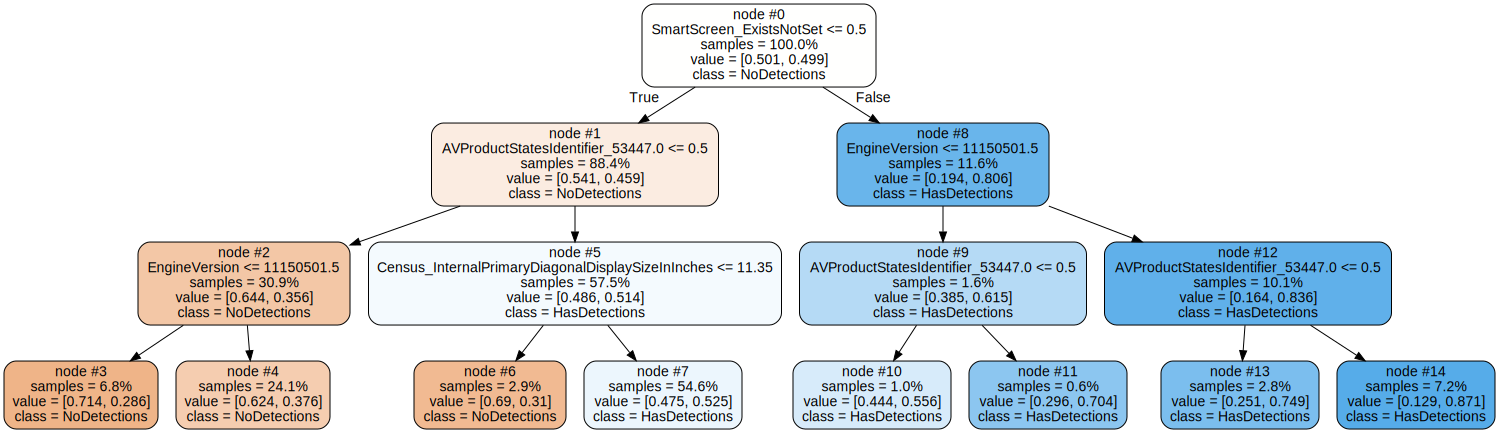

In [325]:
graphviz.Source(tree_graph)

#### Evaluación del modelo

In [326]:
y_test_pred = pd.DataFrame(dt.predict(X_test), index=X_test.index, columns=['HasDetectionPrediction'])

In [327]:
y_test_pred.head()

,HasDetectionPrediction
MachineIdentifier,
fcebd8a8d9b9fdccfe4a31dad489498a,1
bc810e2cb86b2a410a3f841d987fc5f7,0
4264f3df8d08bc723e43b340e34bfd73,1
557d425ab6a4e92a1fc94fc1dd7617ba,1
fad309cbe059e066512d18d570c3e1d4,1


In [328]:
y_test.head()

,Target
MachineIdentifier,
fcebd8a8d9b9fdccfe4a31dad489498a,1
bc810e2cb86b2a410a3f841d987fc5f7,0
4264f3df8d08bc723e43b340e34bfd73,1
557d425ab6a4e92a1fc94fc1dd7617ba,1
fad309cbe059e066512d18d570c3e1d4,1


In [329]:
df_results = y_test.join(y_test_pred)

In [330]:
df_results.head(20)

,Target,HasDetectionPrediction
MachineIdentifier,,
fcebd8a8d9b9fdccfe4a31dad489498a,1,1
bc810e2cb86b2a410a3f841d987fc5f7,0,0
4264f3df8d08bc723e43b340e34bfd73,1,1
557d425ab6a4e92a1fc94fc1dd7617ba,1,1
fad309cbe059e066512d18d570c3e1d4,1,1
3a87598e4e76875caaed928b2e2c86d8,1,1
b215fe58bb72c5d523b674bcd96a3dcb,0,0
57d954d4234577b91181bd6f9a11eb93,0,1
fbe93db4f18bb9178bb5a280e9760799,0,0


In [331]:
df_results['Success'] = (df_results['Target'] == df_results['HasDetectionPrediction']).astype(int)

In [332]:
df_results.head(10)

,Target,HasDetectionPrediction,Success
MachineIdentifier,,,
fcebd8a8d9b9fdccfe4a31dad489498a,1,1,1
bc810e2cb86b2a410a3f841d987fc5f7,0,0,1
4264f3df8d08bc723e43b340e34bfd73,1,1,1
557d425ab6a4e92a1fc94fc1dd7617ba,1,1,1
fad309cbe059e066512d18d570c3e1d4,1,1,1
3a87598e4e76875caaed928b2e2c86d8,1,1,1
b215fe58bb72c5d523b674bcd96a3dcb,0,0,1
57d954d4234577b91181bd6f9a11eb93,0,1,0
fbe93db4f18bb9178bb5a280e9760799,0,0,1


In [333]:
df_results['Success'].count()

80000

In [334]:
df_results['Success'].sum()

48037

In [335]:
df_results['Success'].mean()

0.6004625

Tenemos un modelo con un **Accuracy** del 60%, antes sin hacer nada teniamos un 49,99%.

Vamos a construir la matrz de confusión para ver como hemo sido capacez de predecir con nuestro modelo.

In [336]:
confusion_matrix = pd.crosstab(df_results['Target'], df_results['HasDetectionPrediction'])

In [337]:
confusion_matrix

HasDetectionPrediction,0,1
Target,,
0,17557,22292
1,9671,30480


In [338]:
TP = confusion_matrix.iloc[1,1]
TN = confusion_matrix.iloc[0,0]
FP = confusion_matrix.iloc[0,1]
FN = confusion_matrix.iloc[1,0]

In [339]:
accuracy = (TP + TN) / (TP + TN + FP + FN)

In [340]:
accuracy

0.6004625

In [341]:
metrics.accuracy_score(df_results['Target'], df_results['HasDetectionPrediction'])

0.6004625

In [342]:
y_test_prob = pd.DataFrame(dt.predict_proba(X_test)[:,1], index=X_test.index, columns=['HasDetectionProbability'])

In [343]:
y_test_prob.head()

,HasDetectionProbability
MachineIdentifier,
fcebd8a8d9b9fdccfe4a31dad489498a,0.52
bc810e2cb86b2a410a3f841d987fc5f7,0.38
4264f3df8d08bc723e43b340e34bfd73,0.87
557d425ab6a4e92a1fc94fc1dd7617ba,0.87
fad309cbe059e066512d18d570c3e1d4,0.87


In [344]:
df_results = df_results.join(y_test_prob)

In [345]:
df_results

,Target,HasDetectionPrediction,Success,HasDetectionProbability
MachineIdentifier,,,,
fcebd8a8d9b9fdccfe4a31dad489498a,1,1,1,0.52
bc810e2cb86b2a410a3f841d987fc5f7,0,0,1,0.38
4264f3df8d08bc723e43b340e34bfd73,1,1,1,0.87
557d425ab6a4e92a1fc94fc1dd7617ba,1,1,1,0.87
fad309cbe059e066512d18d570c3e1d4,1,1,1,0.87
...,...,...,...,...
7a570a1b51ddb46413ba172717e964ba,0,1,0,0.52
cbe0af488ddb6aa8919b2e79b30b775f,0,1,0,0.52
76748a88123e598872ec7f2434bd82e0,1,1,1,0.87


In [346]:
df_results.pivot_table(index='HasDetectionProbability', values='Success', aggfunc=[len, np.sum, np.mean])

,len,sum,mean
,Success,Success,Success
HasDetectionProbability,,,
0.29,5438,3886,0.71
0.31,2311,1576,0.68
0.38,19479,12095,0.62
0.52,43454,22939,0.53
0.56,759,432,0.57
0.70,490,344,0.70
0.75,2319,1770,0.76
0.87,5750,4995,0.87


#### Prueba de alternativas

A continuación vamos a probar con diferentes profundidades para ver cual nos da un mejor resultado. Para ello para a realizar un total de 20 pruebas, desde 1 profundidad has un arbol de profundidad 20.

In [347]:
for i in range(1, 21):
    dt = DecisionTreeClassifier(max_depth=i, random_state=RANDOM_STATE)
    dt.fit(X_train, y_train)
    test_score = dt.score(X_test, y_test)
    print('Árbol de profundidad {}. Score en test: {}'.format(i, test_score))

Árbol de profundidad 1. Score en test: 0.5701625
Árbol de profundidad 2. Score en test: 0.58995
Árbol de profundidad 3. Score en test: 0.6004625
Árbol de profundidad 4. Score en test: 0.599475
Árbol de profundidad 5. Score en test: 0.604425
Árbol de profundidad 6. Score en test: 0.6145
Árbol de profundidad 7. Score en test: 0.6150375
Árbol de profundidad 8. Score en test: 0.6158375
Árbol de profundidad 9. Score en test: 0.6165125
Árbol de profundidad 10. Score en test: 0.619575
Árbol de profundidad 11. Score en test: 0.621375
Árbol de profundidad 12. Score en test: 0.6230875
Árbol de profundidad 13. Score en test: 0.62035
Árbol de profundidad 14. Score en test: 0.622075
Árbol de profundidad 15. Score en test: 0.623
Árbol de profundidad 16. Score en test: 0.6230875
Árbol de profundidad 17. Score en test: 0.621175
Árbol de profundidad 18. Score en test: 0.6199125
Árbol de profundidad 19. Score en test: 0.6159875
Árbol de profundidad 20. Score en test: 0.6134875


#### Probamos con el ROC - AUC

In [348]:
metrics.roc_auc_score(df_results['Target'], df_results['HasDetectionProbability']) 

0.6406945371725887

Vamos a dibujar la curva

In [349]:
fpr, tpr, thresholds = metrics.roc_curve(df_results['Target'], df_results['HasDetectionProbability'])

In [350]:
thresholds

array([1.87060144, 0.87060144, 0.74903304, 0.7039801 , 0.55588332,
       0.52452716, 0.37567929, 0.31028939, 0.28631298])

In [351]:
fpr

array([0.        , 0.01894652, 0.03272353, 0.03638736, 0.04459334,
       0.55941178, 0.86293257, 0.90248187, 1.        ])

In [352]:
tpr

array([0.        , 0.12440537, 0.16848895, 0.17705661, 0.18781599,
       0.75913427, 0.94304002, 0.96134592, 1.        ])

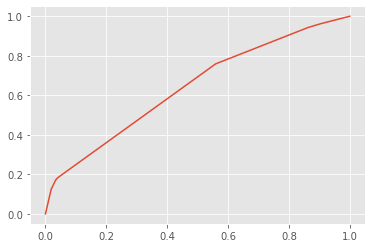

In [353]:
plt.plot(fpr, tpr)

Nos quedamos con el DT de profundidad 12, que es el que mejor score tiene.

In [354]:
dt = DecisionTreeClassifier(max_depth=12, random_state=RANDOM_STATE)

In [355]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=12, random_state=42)

In [356]:
dt_predictions = pd.DataFrame(dt.predict_proba(X_test)[:,1], index=X_test.index, columns=['HasDetectionProbability'])

In [357]:
dt_predictions.head()

,HasDetectionProbability
MachineIdentifier,
fcebd8a8d9b9fdccfe4a31dad489498a,0.71
bc810e2cb86b2a410a3f841d987fc5f7,0.29
4264f3df8d08bc723e43b340e34bfd73,1.00
557d425ab6a4e92a1fc94fc1dd7617ba,0.83
fad309cbe059e066512d18d570c3e1d4,0.81


In [358]:
metrics.roc_auc_score(y_test, dt_predictions)

0.673767090352142

#### Probamos RandomForest

In [359]:
rf = RandomForestClassifier(max_depth=7, random_state=RANDOM_STATE, n_estimators = 100)

In [360]:
rf.fit(X_train, y_train)

<ipython-input-360-168a6fc83696>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


RandomForestClassifier(max_depth=7, random_state=42)

In [361]:
rf_predictions = pd.DataFrame(rf.predict_proba(X_test)[:,1], index=X_test.index, columns=['HasDetectionProbability'])

In [362]:
metrics.roc_auc_score(y_test, rf_predictions)

0.6792621330349345

Con el modelo **RandomForest** mejoramos en 0,0055 el AUC. Pasamos de un 0.6737 a un **0.6792**.

#### Probamos XGBoost

In [363]:
xgb = XGBClassifier(max_depth = 7, random_state = RANDOM_STATE, n_estimators = 100, verbosity=1)

In [364]:
xgb.fit(X_train, y_train)

C:\Users\jordi\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=1)

In [365]:
xgb_predictions = pd.DataFrame(xgb.predict_proba(X_test)[:,1], index=X_test.index, columns=['HasDetectionProbability'])

In [366]:
metrics.roc_auc_score(y_test, xgb_predictions)

0.7090760460268285

Con el **XGBoost** hemos mejorado el **AUC** en 3 puntos, hasta un **0.7091**.

#### Validación

Ahora solo nos falta validar nuestro modelo. Para ello vamos a utlizar nuestro set de validación que hemos creado anteriormente.

In [367]:
xgb_predictions_val = pd.DataFrame(xgb.predict_proba(X_val)[:,1], index=X_val.index, columns=['HasDetectionProbability'])

In [368]:
metrics.roc_auc_score(y_val, xgb_predictions_val)

0.70675836888295

Por lo que se ve, parece que teniamos un poco de un poco sobreajuste en test. Nuestra predicción final es de un **AUC 0,71.**

### ML CANVAS

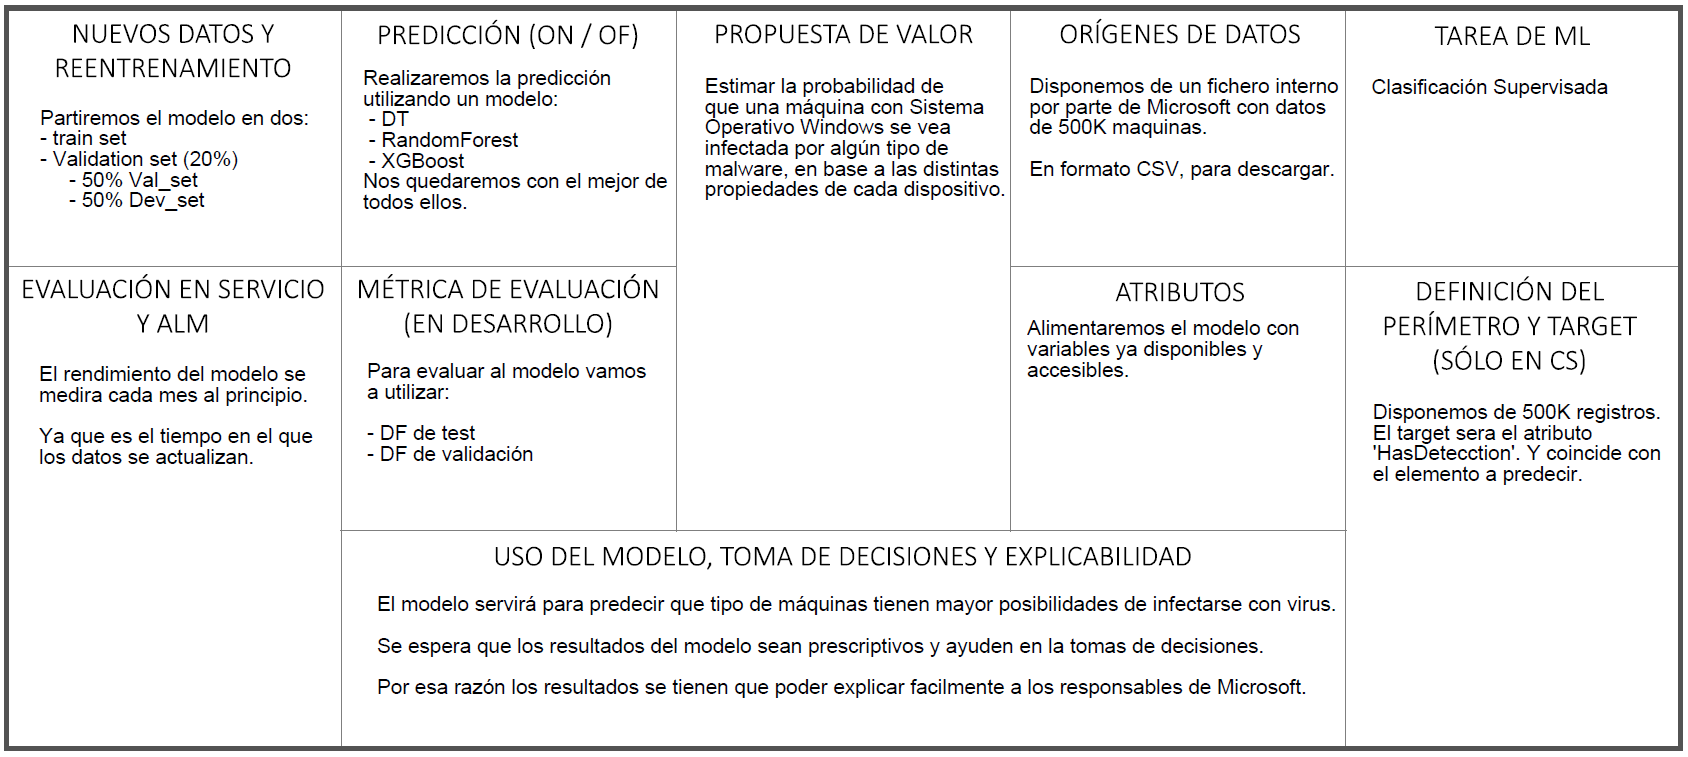